# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data.

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [ ]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/Beatrice-cyber/comp0188_cw2_public.git
    !pip install typeguard==2.13.3

Mounted at /content/drive
  Cloning https://github.com/joshuaspear/pymlrf.git to /tmp/pip-req-build-cy5u_8w4
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/pymlrf.git /tmp/pip-req-build-cy5u_8w4
  Resolved https://github.com/joshuaspear/pymlrf.git to commit 2e86313edd7900c1b5621b4e31368a36328b69f8
  Preparing metadata (setup.py) ... done
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20447 sha256=cb9a09c9819c4755fdffac6badc825274fa419651e8d60b3b352c6f1db67a947
  Stored in directory: /tmp/pip-ephem-wheel-cache-cl6aw5ih/wheels/b5/e9/53/587b30108dd50ceffb743ada10dd85037096182424fb2c907e
Successfully built pymlrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/Beatrice-cyber/comp0188_cw2_public.git to /tmp/pip-req-build-pjo866s_
  Running command git clone --filter=blob:none --quiet https://github.com/Beatrice-cyber/comp0188_cw2_public.git /tmp/pip-req-build-pjo866s_
 

Ignore the error:
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [ ]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = False
print(project_options.debug)

True
True


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy
from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

2025-01-02 09:28:38,155 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [ ]:
print(train_dh.loc)

/content/drive/MyDrive/comp0188_2425/cw2/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [ ]:
# from comp0188_cw2.Preprocessing import main
# RUN_PREPROCESSING = True
# if RUN_PREPROCESSING:
#     main()

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [ ]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]

train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)
test_nps = load_all_files(test_dh.loc,"test_[0-9].h5", keys=_keys)

100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output.

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [ ]:
# ******* INSERT YOUR CODE HERE *******
global_transforms = {
    "front_cam_ob":
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x / 255.0)
            ]),

    "mount_cam_ob": transforms.Compose([
             transforms.ToTensor(),
            transforms.Lambda(lambda x: x / 255.0)
            ]),
    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: torch.tensor(x),
    "ee_cartesian_vel_ob": lambda x: torch.tensor(x),
    "joint_pos_ob": lambda x: torch.tensor(x)
}

# ******* INSERT YOUR CODE HERE - END *******

###EDA analysis

In [ ]:
import pandas as pd
import os
import logging
import h5py
import matplotlib.pyplot as plt
import numpy as np
from comp0188_cw2 import project_options
from comp0188_cw2.utils import to_greyscale
from comp0188_cw2.config import FILE_PATH, ROOT_PATH

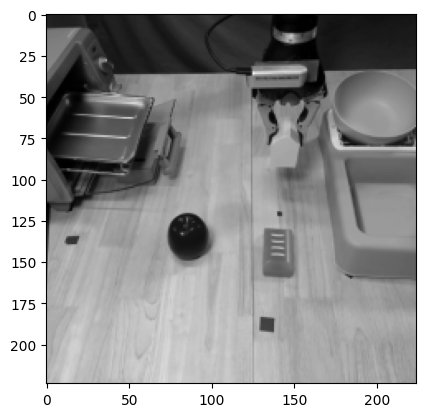

Shape: (224, 224), Range: 0.896484375 to 233.0
Action: [0.      0.      0.03072 1.     ], Shape :(4,)


In [ ]:
front_cam = train_nps["front_cam_ob"][0]
plt.imshow(front_cam, cmap="gray")
plt.show()
print(f"Shape: {front_cam.shape}, Range: {front_cam.min()} to {front_cam.max()}")
action = train_nps["actions"][0]
print(f"Action: {action}, Shape :{action.shape}")

In [ ]:
tran_df = pd.read_csv(os.path.join(ROOT_PATH, "transition_df.csv"))
tran_df.head()
tran_df.describe()

episode    terminated        reward  max_reward  episode_length
count  77965.000000  77965.000000  77965.000000     77965.0    77965.000000
mean     549.125608      0.013917      0.013917         1.0       78.975374
std      316.266955      0.117145      0.117145         0.0       23.721919
min        0.000000      0.000000      0.000000         1.0       22.000000
25%      274.000000      0.000000      0.000000         1.0       63.000000
50%      553.000000      0.000000      0.000000         1.0       76.000000
75%      824.000000      0.000000      0.000000         1.0       92.000000
max     1084.000000      1.000000      1.000000         1.0      195.000000

episode           0
terminated        0
reward            0
max_reward        0
episode_length    0
dtype: int64


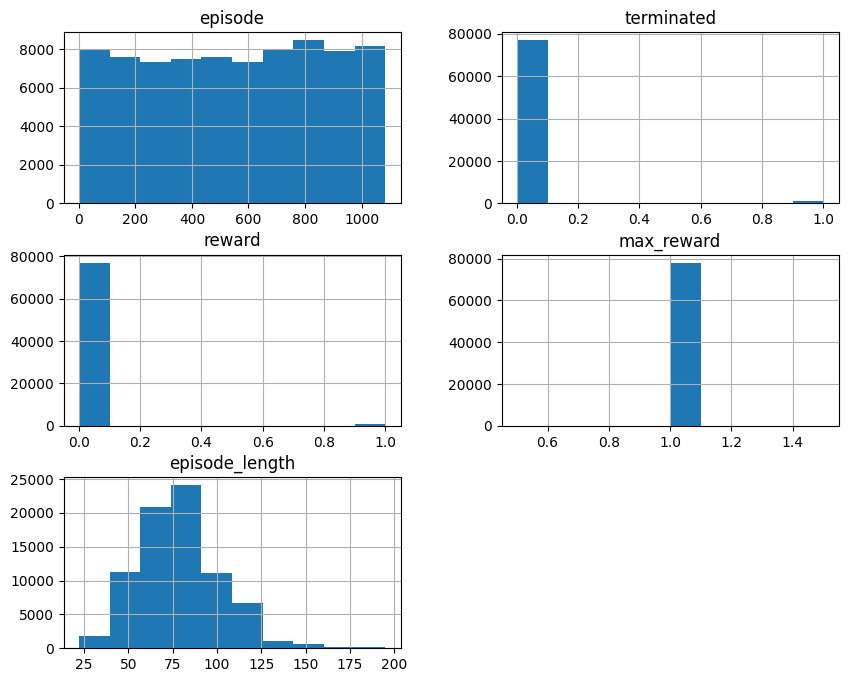

In [ ]:
print(tran_df.isnull().sum())  # Check for missing values
tran_df.hist(figsize=(10, 8))
plt.show()

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.


The evidence are in eda_example because the data was 23GB and does not fit onto google colab, therefore I ran the EDA locally.

_actions_:This should be used against the output of the model to see how good the predictions are. I did not mutate this dataset as this is just a 2D array with an element being an array of 4 and contains mainly useful information. By random sampling from the array, it has a mean of 0.25291992671380287, std is 0.5257724531141624.


_front_cam_ob_: I did not apply a grayscale to front camera images since the preprocessing has already done that in the code, but did rescale from 0 to 1  <br>
```python
process_data_lkp = {
    "front_cam_ob": lambda x: to_greyscale(x.astype(int)).astype(np.float16),
    "mount_cam_ob": lambda x: to_greyscale(x.astype(int)).astype(np.float16),
    ...
}
```


I did not resize the images since the shape of the image were consistent(dimension 224x224x3). I did not crop the image at all as this would mean that all the information outside of the crop will be lost. After running it, I also found out that sharpening the images did not help with prediction either even though in theory, sharpen the images make image detection easier.
I also tried normalizing the images, this does not have a huge effect on the model performance, so I did not include this preprocess.


_mount_cam_ob_:  I also did not resize the image since the dimension was consistent(224x224x3), and no cropping either, the same process as front camera.


_ee_cartesian_pos_ob_: The mean for the cartesian position is 0.12264599865017001, and std is 0.4152677221635258. As this is in nearly same range with actions, normalisation is not needed.

_ee_cartesian_vel_ob_: There are no missing values, no NaN, the mean is 0.0018656390471071683, std is 0.08673713083639709. The range of values are quite close to cartesian_pos_ob hence, there is no need to rescale.


_joint_pos_ob_: The mean is 0.7344366964069835, std is 1.5789464399686788. The standard deviation is slightly bigger than cartisian velocity abd catesian position, however, it does not need normlisation either.

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which:
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

The composite loss takes both the image data and the continuous values into account. The mean squared error(pos_criterion) calculates the error for the position and orientation of the robot arm. The grp criterion is using the cross entropy loss, this calculates the error of whether the arm should open, close or hold.
In this way, by combining both functions, we are evluating the error of the predicting in both the position of the robot and movement of the arm.

In [ ]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [ ]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": False,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


25469
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(1.5314, device='cuda:0')


In [ ]:
mo = WandBMetricOrchestrator()

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(),
    # half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "End_to_end_1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

wandb: Currently logged in as: beatrice-z (beatrice-z-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:44<00:00, 38.80it/s]
INFO:cw2_logger:epoch 1	 training loss : 0.5963898301124573
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.6577208638191223 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:44<00:00, 38.76it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.35470983386039734
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.7496078014373779 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:43<00:00, 38.85it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.2617393434047699
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 1.0148361921310425 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:43<00:00, 38.93it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.20345774292945862
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 valid

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

####**Answers**

 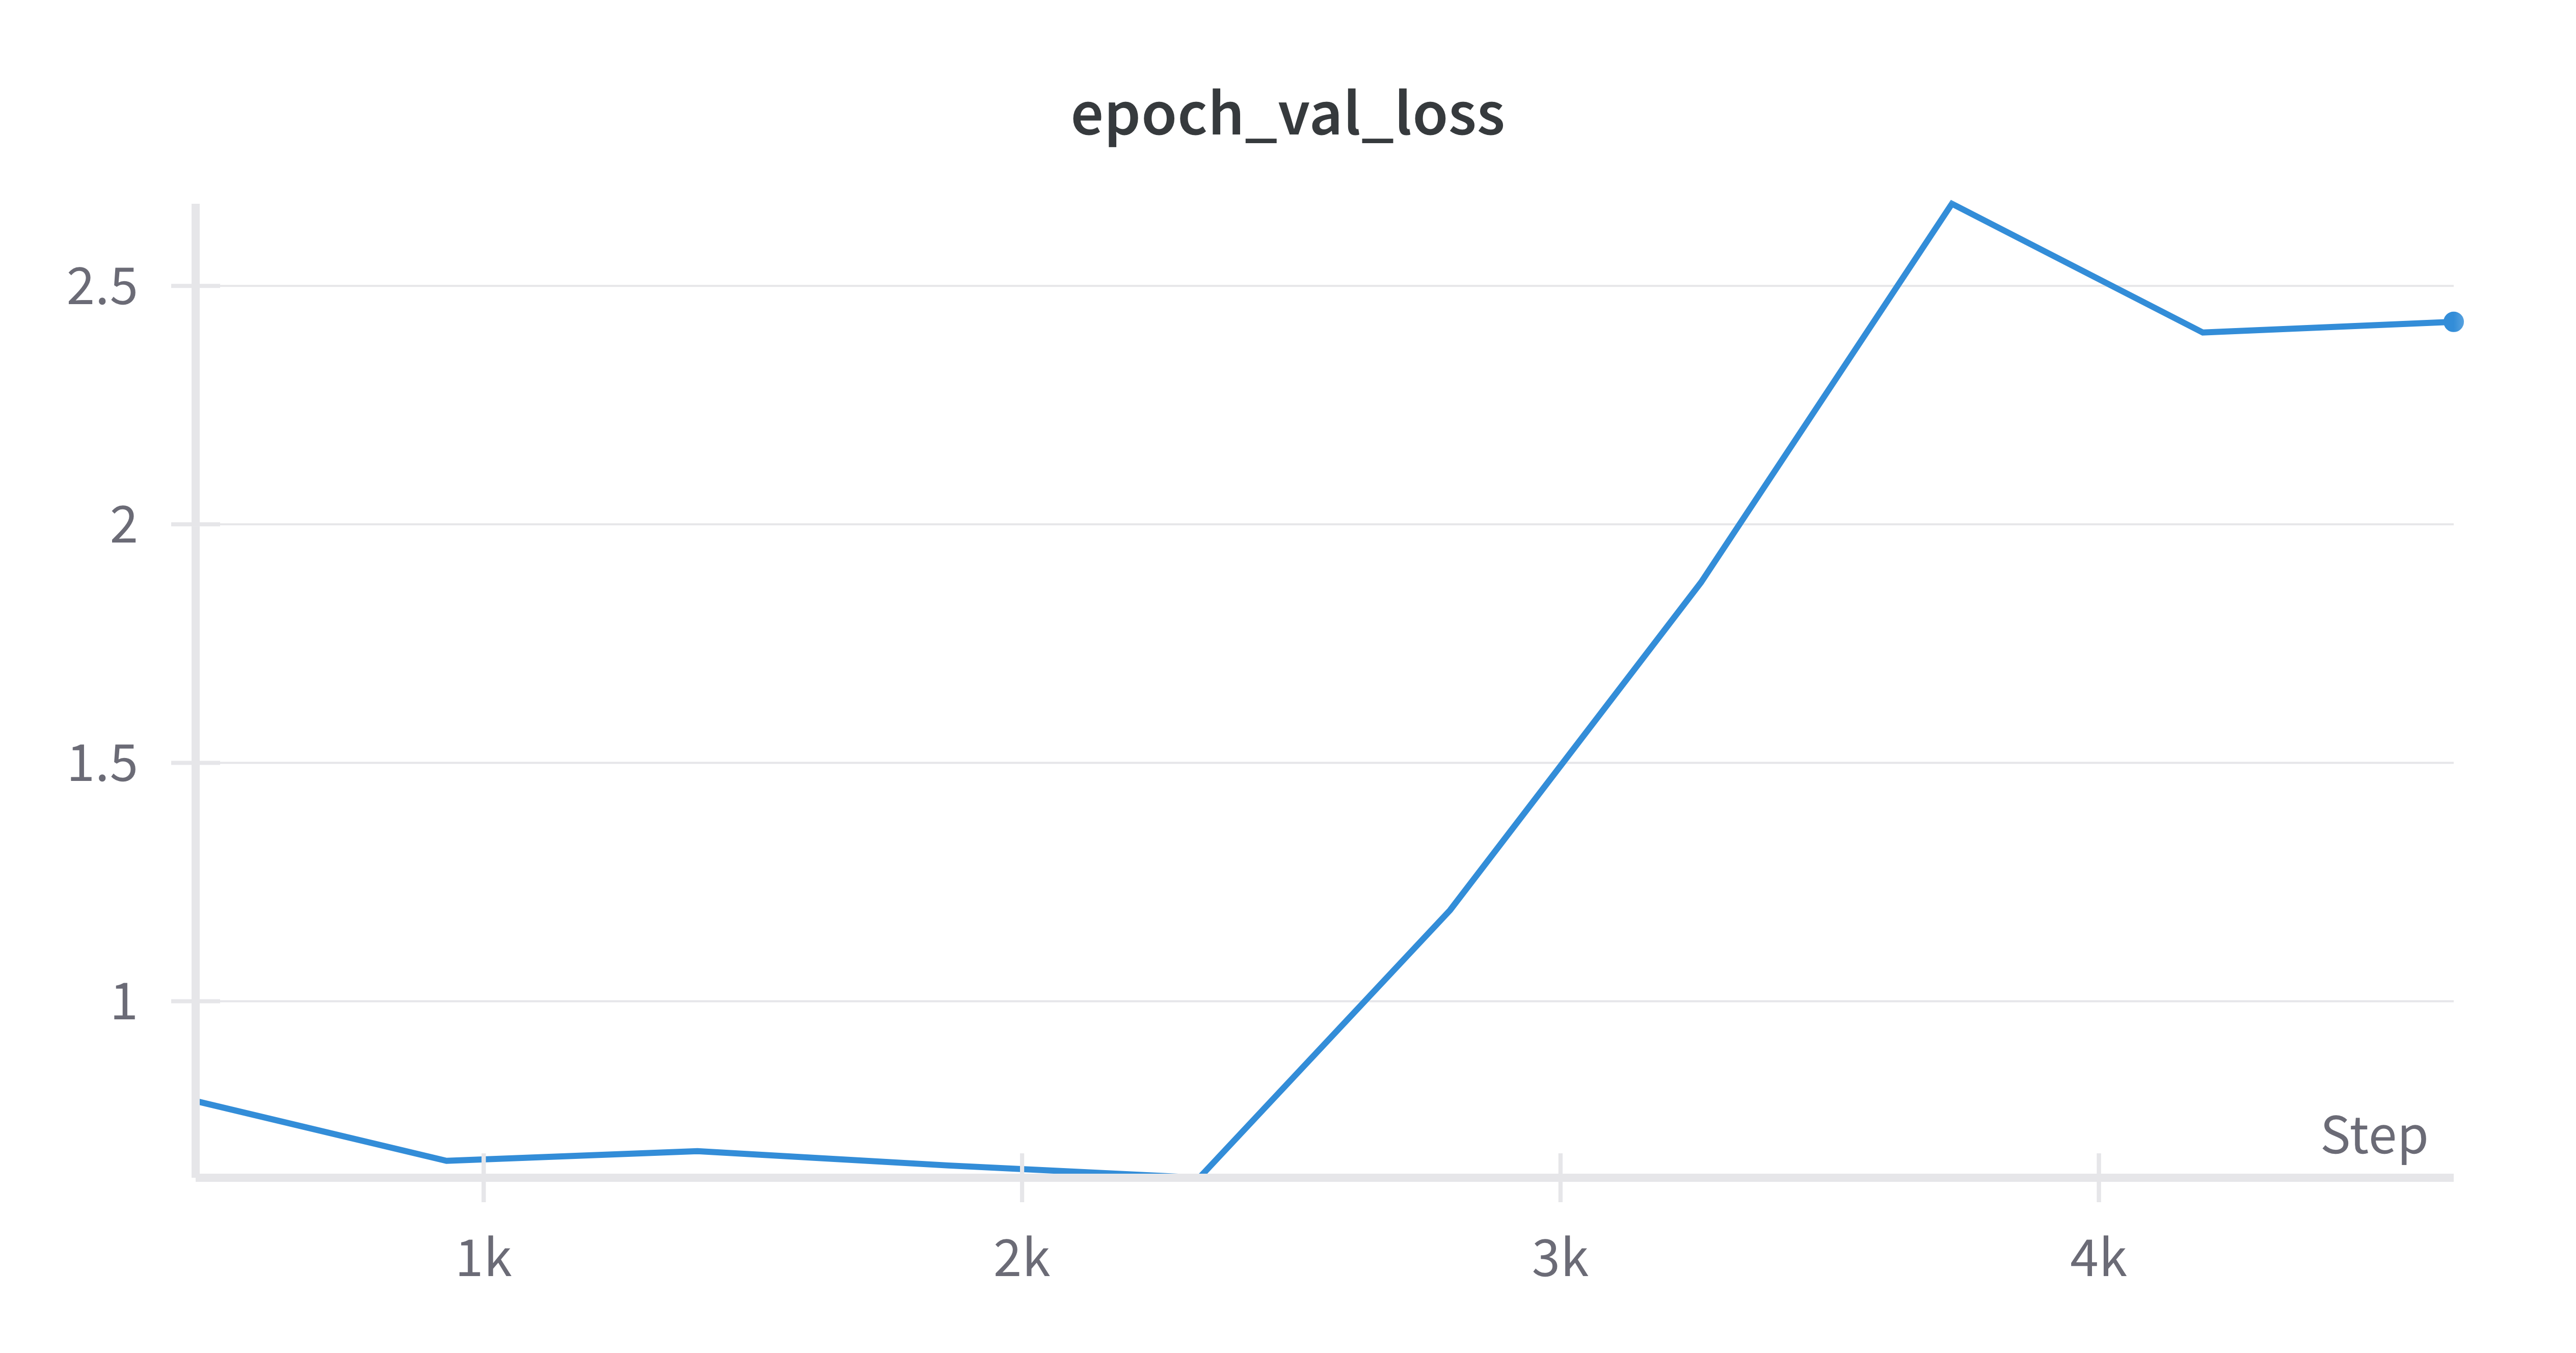

In [ ]:
 1 INFO:cw2_logger:Running epochs: 10
 2 INFO:cw2_logger:Running training epoch
 3 100%|██████████| 319/319 [01:25<00:00,  3.71it/s]
 4 INFO:cw2_logger:epoch 1  training loss : 4.200547695159912
 5 INFO:cw2_logger:Running validation
 6 INFO:cw2_logger:epoch 1  validation loss : 0.790802538394928
 7 INFO:cw2_logger:Running training epoch
 8 100%|██████████| 319/319 [01:23<00:00,  3.80it/s]
 9 INFO:cw2_logger:epoch 2  training loss : 0.7315367460250854
10 INFO:cw2_logger:Running validation
11 INFO:cw2_logger:epoch 2  validation loss : 0.6653720736503601
12 INFO:cw2_logger:Running training epoch
13 100%|██████████| 319/319 [01:52<00:00,  2.84it/s]
14 INFO:cw2_logger:epoch 3  training loss : 0.6756235957145691
15 INFO:cw2_logger:Running validation
16 INFO:cw2_logger:epoch 3  validation loss : 0.685674250125885
17 INFO:cw2_logger:Running training epoch
18 100%|██████████| 319/319 [01:43<00:00,  3.08it/s]
19 INFO:cw2_logger:epoch 4  training loss : 0.676077127456665
20 INFO:cw2_logger:Running validation
21 INFO:cw2_logger:epoch 4  validation loss : 0.6556317806243896
22 INFO:cw2_logger:Running training epoch
23 100%|██████████| 319/319 [01:42<00:00,  3.12it/s]
24 INFO:cw2_logger:epoch 5  training loss : 0.5689704418182373
25 INFO:cw2_logger:Running validation
26 INFO:cw2_logger:epoch 5  validation loss : 0.6298708319664001
27 INFO:cw2_logger:Running training epoch
28 100%|██████████| 319/319 [01:36<00:00,  3.31it/s]
29 INFO:cw2_logger:epoch 6  training loss : 0.3735102117061615
30 INFO:cw2_logger:Running validation
31 INFO:cw2_logger:epoch 6  validation loss : 1.1911699771881104
32 INFO:cw2_logger:Running training epoch
33 100%|██████████| 319/319 [01:35<00:00,  3.34it/s]
34 INFO:cw2_logger:epoch 7  training loss : 0.11873296648263931
35 INFO:cw2_logger:Running validation
36 INFO:cw2_logger:epoch 7  validation loss : 1.8782933950424194
37 INFO:cw2_logger:Running training epoch
38 100%|██████████| 319/319 [01:33<00:00,  3.43it/s]
39 INFO:cw2_logger:epoch 8  training loss : 0.12884068489074707
40 INFO:cw2_logger:Running validation
41 INFO:cw2_logger:epoch 8  validation loss : 2.6721560955047607
42 INFO:cw2_logger:Running training epoch
43 100%|██████████| 319/319 [01:37<00:00,  3.28it/s]
44 INFO:cw2_logger:epoch 9  training loss : 0.016000691801309586
45 INFO:cw2_logger:Running validation
46 INFO:cw2_logger:epoch 9  validation loss : 2.40216326713562
47 INFO:cw2_logger:Running training epoch
48 100%|██████████| 319/319 [01:34<00:00,  3.38it/s]
49 INFO:cw2_logger:epoch 10  training loss : 0.0024983850307762623
50 INFO:cw2_logger:Running validation
51 INFO:cw2_logger:epoch 10  validation loss : 2.4246253967285156

#### Answer, Failure modes and evaluation of the model

From the log and chart above, at epoch 4, the validation loss stabilized at 0.62. However, starting from epoch 5, the validation loss spiked to 1.61 and continued to increase, reaching 2.42 by later epochs. In contrast, the training loss kept decreasing steadily. This divergence between training and validation performance clearly indicates that the model started overfitting from epoch 5 onwards.

Additionally, analysis of the gradient values revealed high variance, further suggesting that the model struggles to generalize well to unseen data.

From epoch 5, the model exhibits classic overfitting behavior:
The training loss continues to decline, indicating that the model fits the training data well.
The validation loss increases sharply, signaling poor generalization to unseen data.

Imbalanced contribution to loss, overfitting and gradient instability are the failure modes.

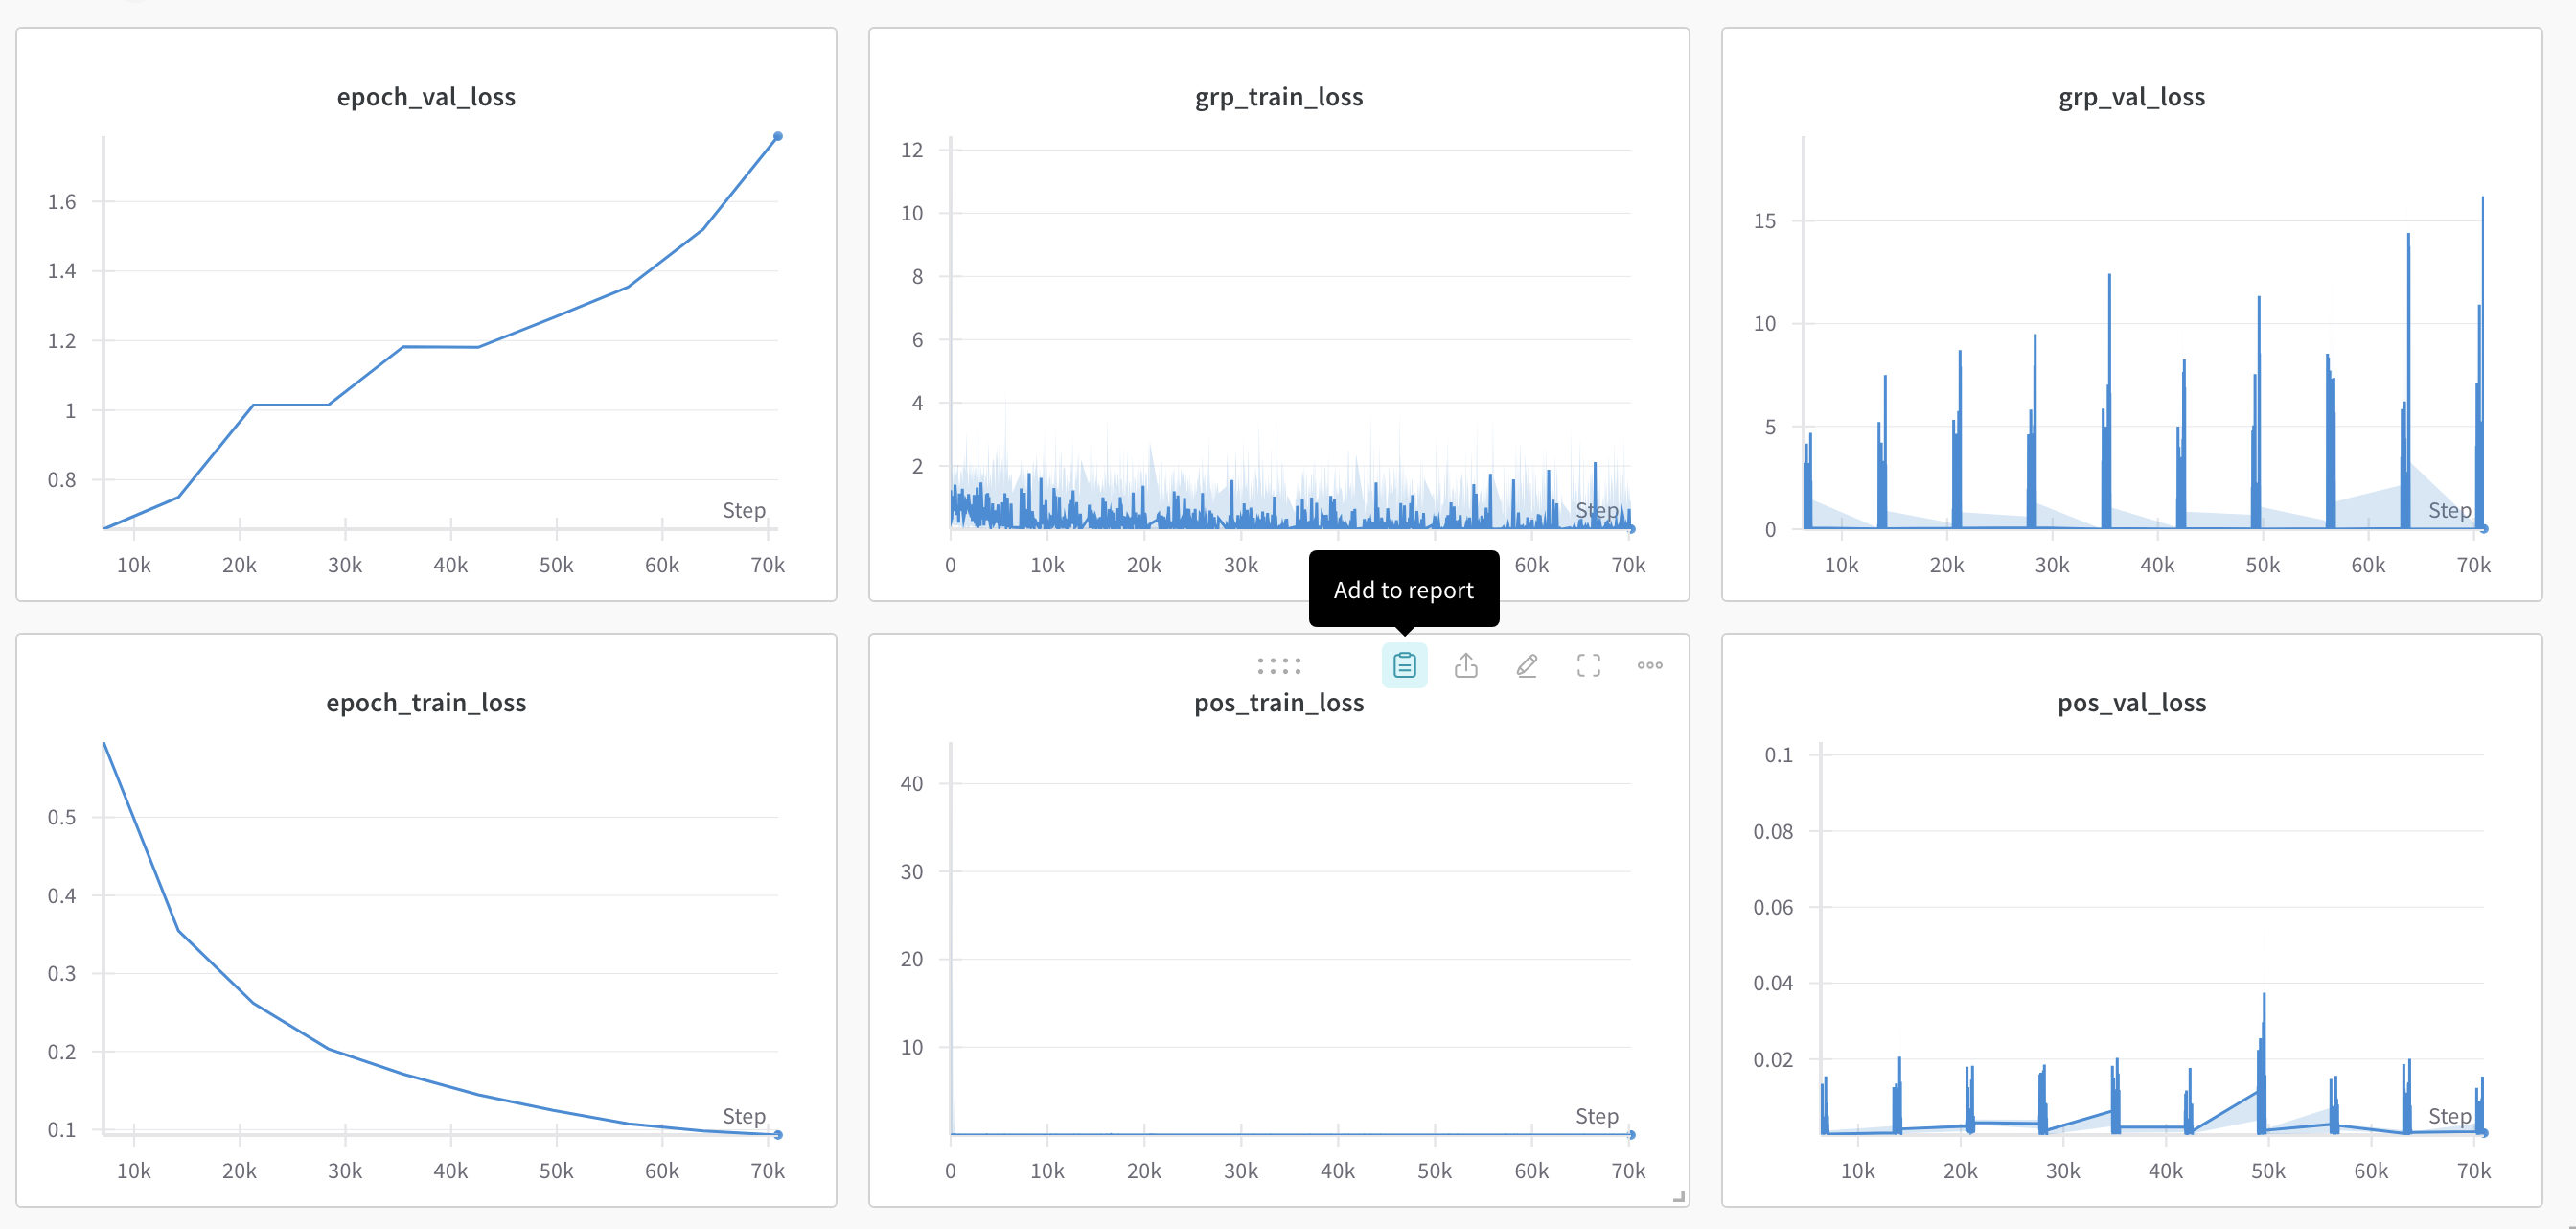

#### Question 1.b.ii.ii Performance evaluation (8 marks)
3 c
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should:
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
wandb_name = "End_to_end_lr"
wandb_grp="End_to_end"

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
trainer_lr = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,  scheduler=scheduler,
    mo=WandBMetricOrchestrator(),
    # half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)
trainer_lr.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()

INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:47<00:00, 37.93it/s]
INFO:cw2_logger:epoch 1	 training loss : 1.0791351795196533
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.6437150239944458 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:46<00:00, 38.14it/s]
INFO:cw2_logger:epoch 2	 training loss : 0.6618093848228455
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.7096630930900574 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:45<00:00, 38.45it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.6558208465576172
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.6979719996452332 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [02:48<00:00, 37.79it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.6309372186660767
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validat

In [ ]:
# ******* INSERT YOUR CODE HERE *******
wandb_name = "Ete_weight_decay"
wandb_grp="End_to_end"
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
trainer2 = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(),
    # half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)
trainer2.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()
# ******* INSERT YOUR CODE HERE - END *******

In [ ]:
# adding dropout layers to improve the performance of the model
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=(2,2)),

        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=(2,2)),

        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class BaselineImproved(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = BaselineImproved(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)
wandb_name = "Ete_BN"
wandb_grp="End_to_end"
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )
trainer_model = TorchTrainingLoop(
    model=model, gpu=True,optimizer= optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(),
    # half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)
trainer_model.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )





INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [03:10<00:00, 33.36it/s]
INFO:cw2_logger:epoch 1	 training loss : 20.763357162475586
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 1	 validation loss : 0.6870328187942505 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [03:11<00:00, 33.30it/s]
INFO:cw2_logger:epoch 2	 training loss : 13.101226806640625
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 2	 validation loss : 0.6981413960456848 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [03:14<00:00, 32.77it/s]
INFO:cw2_logger:epoch 3	 training loss : 0.7004613876342773
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 3	 validation loss : 0.775564968585968 
INFO:cw2_logger:Running training epoch
100%|██████████| 6368/6368 [03:09<00:00, 33.59it/s]
INFO:cw2_logger:epoch 4	 training loss : 0.5820391774177551
INFO:cw2_logger:Running validation
INFO:cw2_logger:epoch 4	 validati

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example:
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### Description: A learning rate scheduler


##### Justification: In this experiment, we used a learning rate scheduler to dynamically adjust the learning rate throughout training. Initially, a higher learning rate allowed the model to make large updates and explore the loss landscape efficiently. Therefore, from the first graph(epoch val loss), the validation loss does not have high variation and not climbing up either. This shows the model has not overfitted yet.


##### Conclusion: As training progressed, the scheduler reduced the learning rate, enabling the model to fine-tune its weights and achieve better convergence. This approach stabilized the validation loss and prevented oscillations observed in early trials with a fixed learning rate.

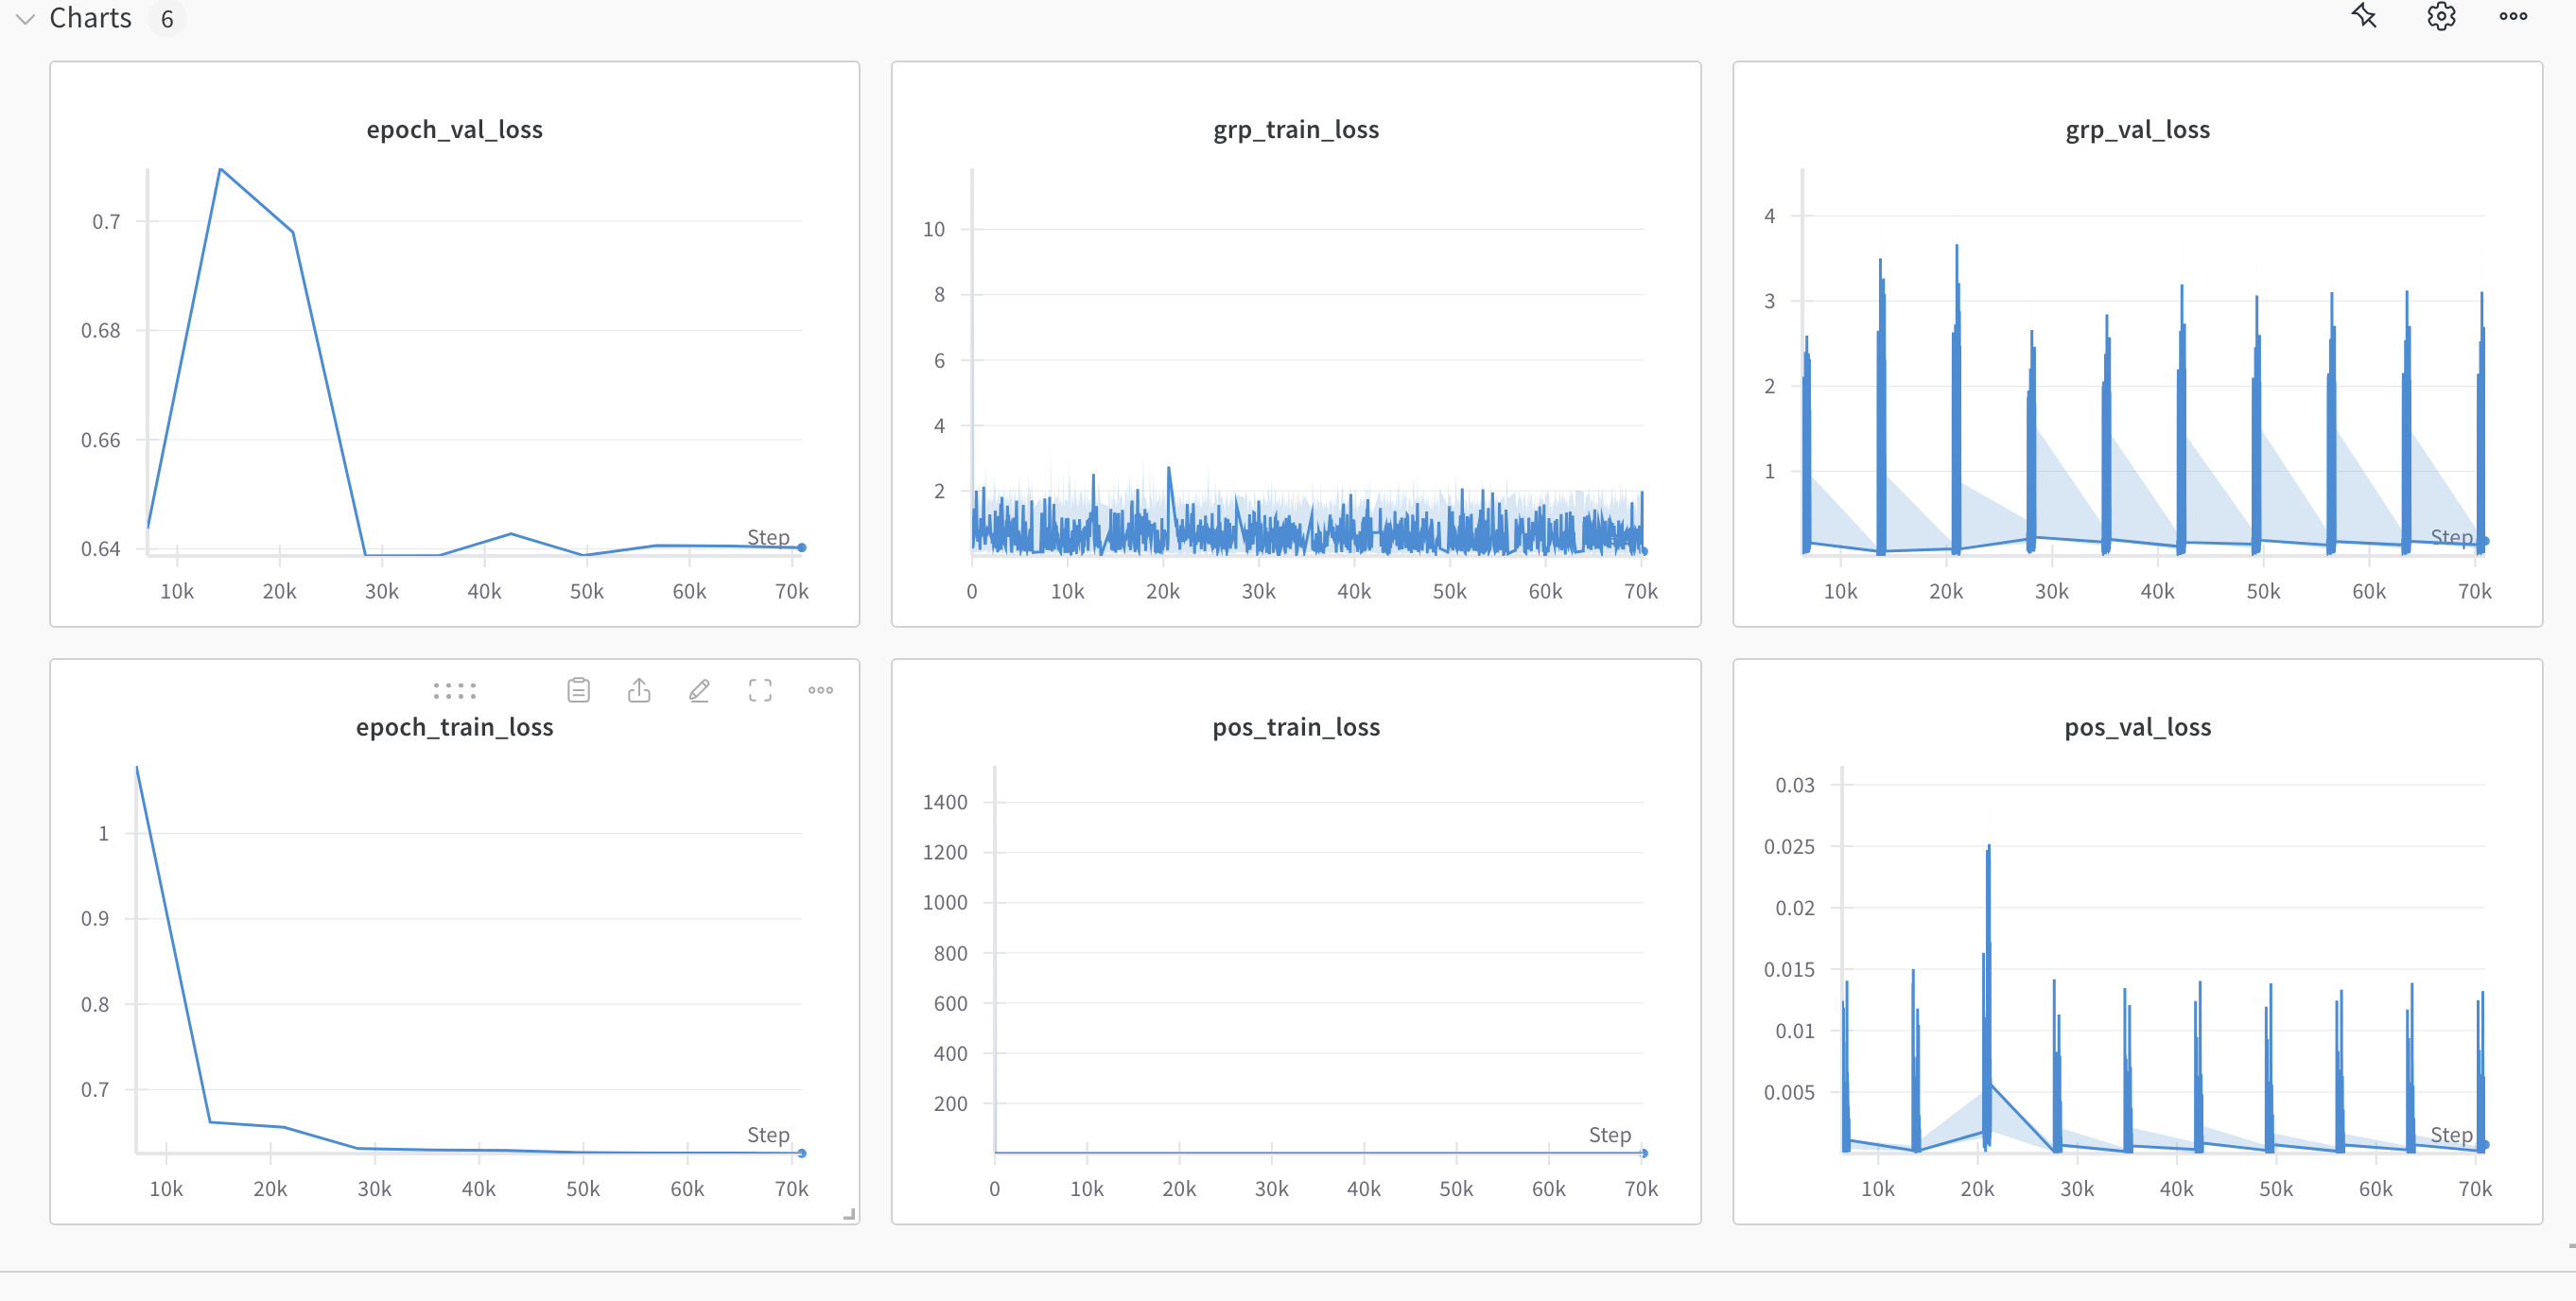

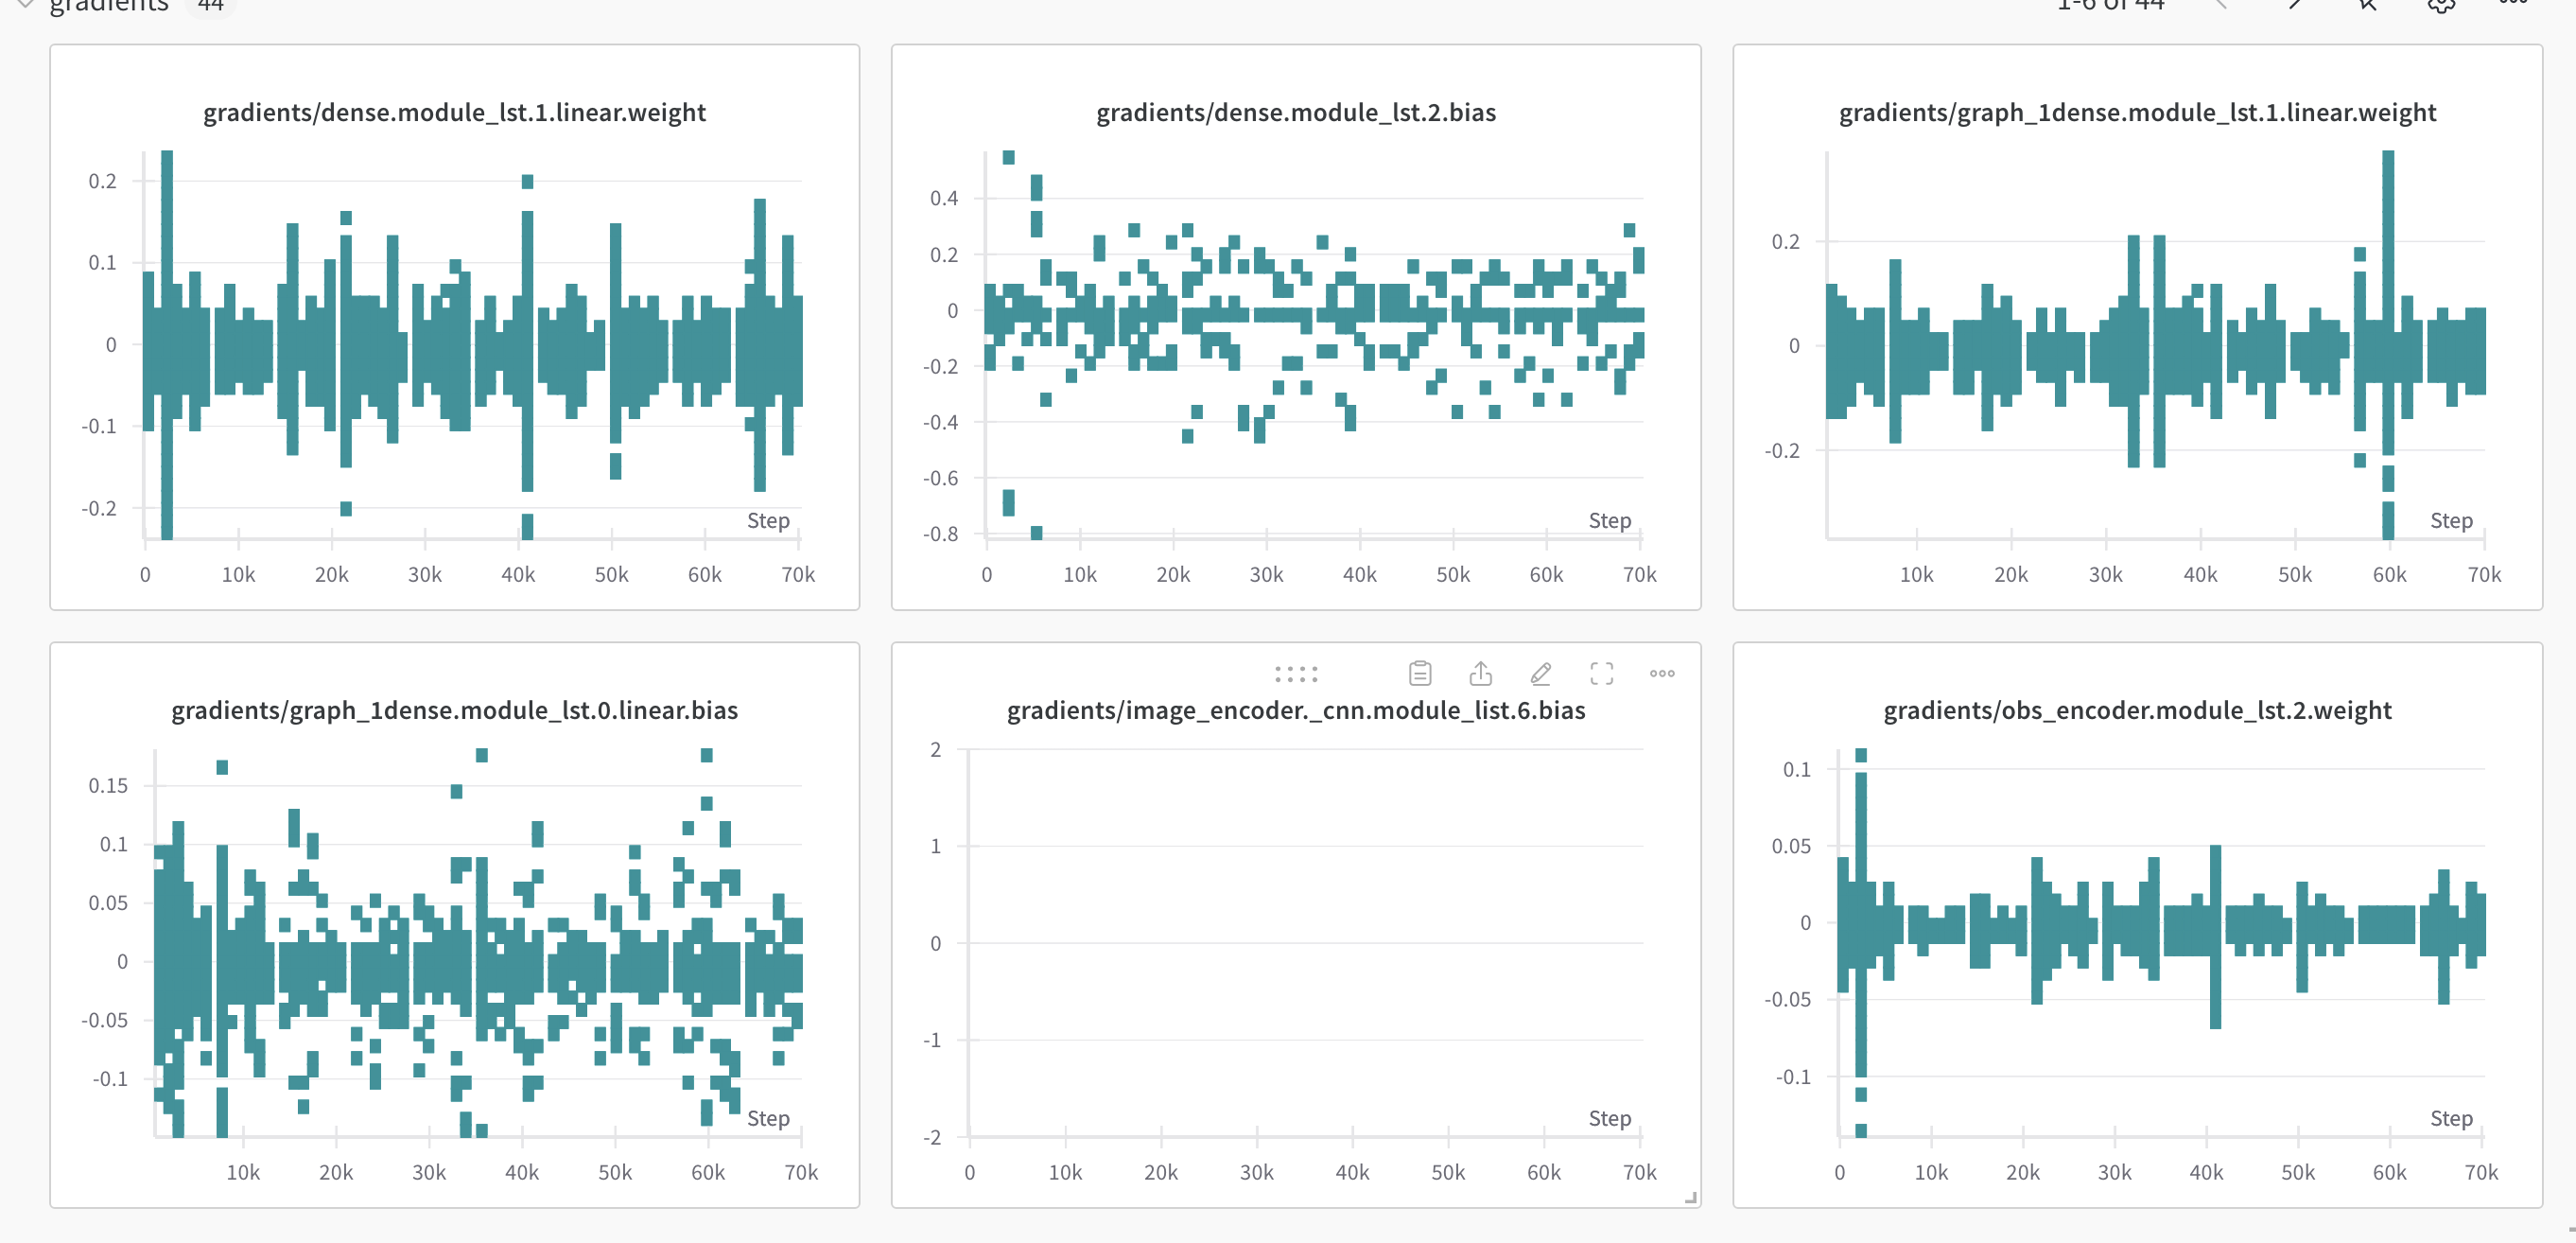

The validation curve without learning rate scheduler: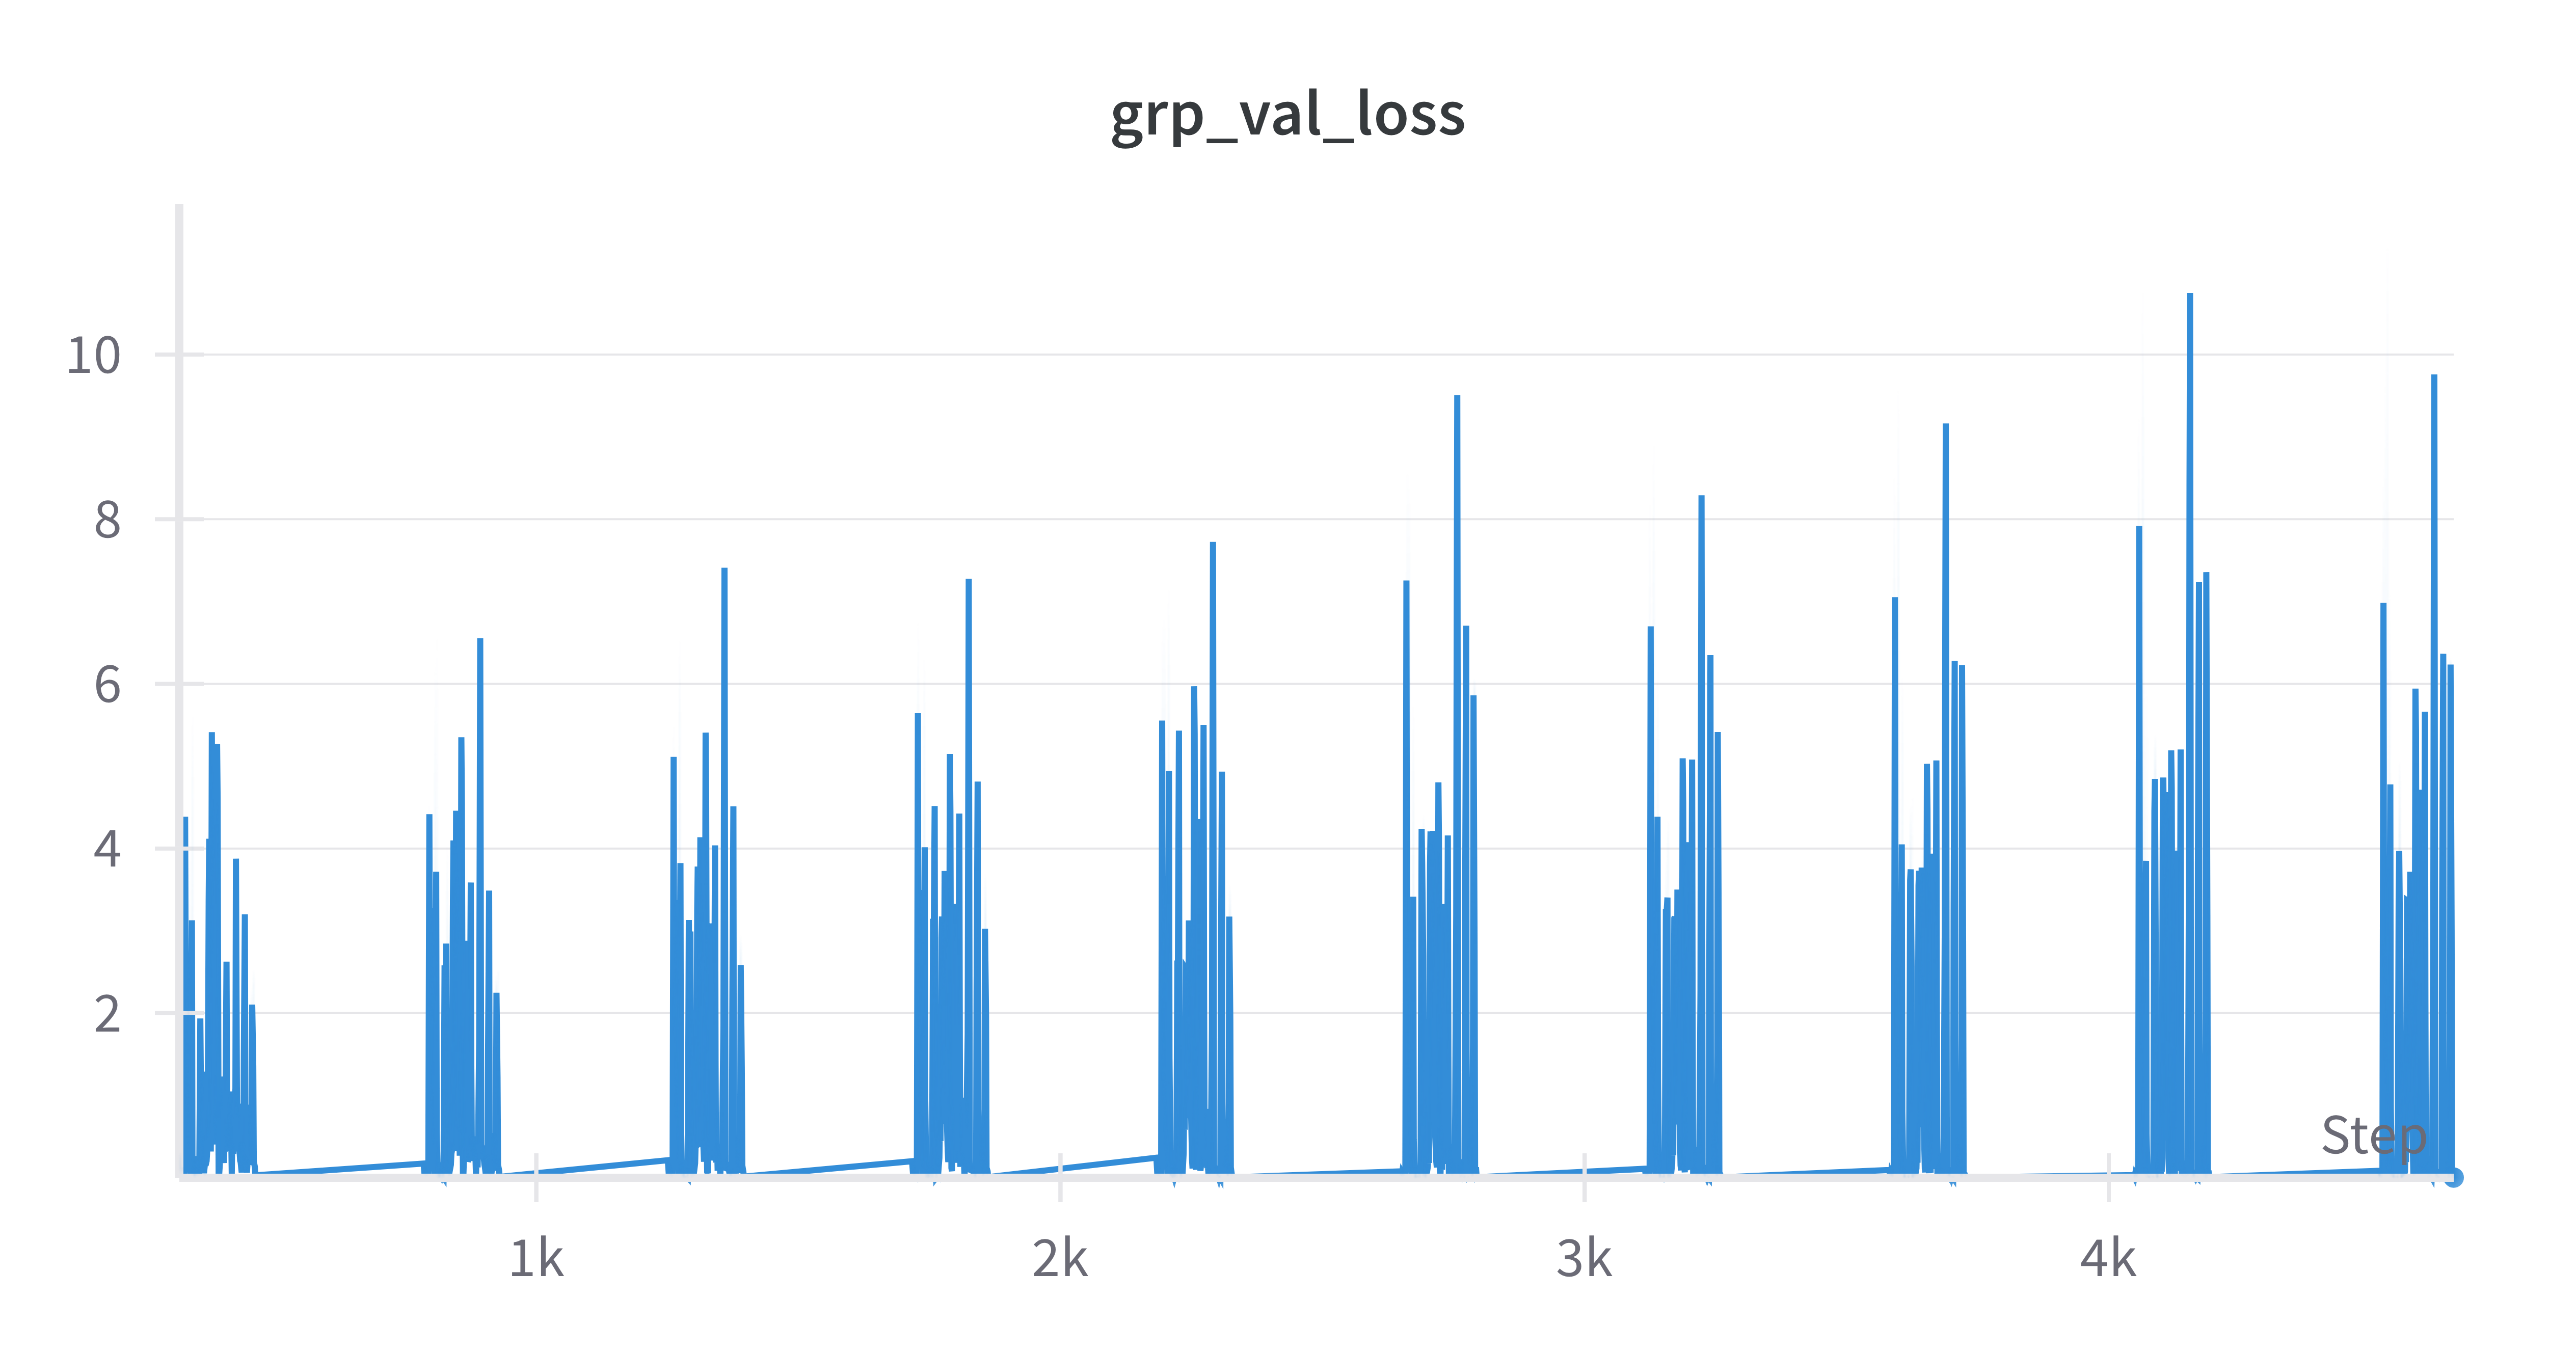

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description: Weight Decay  


##### Justification: The reason to use weight decay is to prevent large gradients and hence less chance to overfit since in base model, it starts to overfit from epoch 6. Comparing with the image above, weight decay reduced grp_val_loss validation loss significantly(10 to 6).

Another reason for weight decay is in the gradient section for basemodel, many gradients were too big (10) because the loss were around 0.5.

##### Conclusion: Weight decay does help generalization and improves the stability of the model.

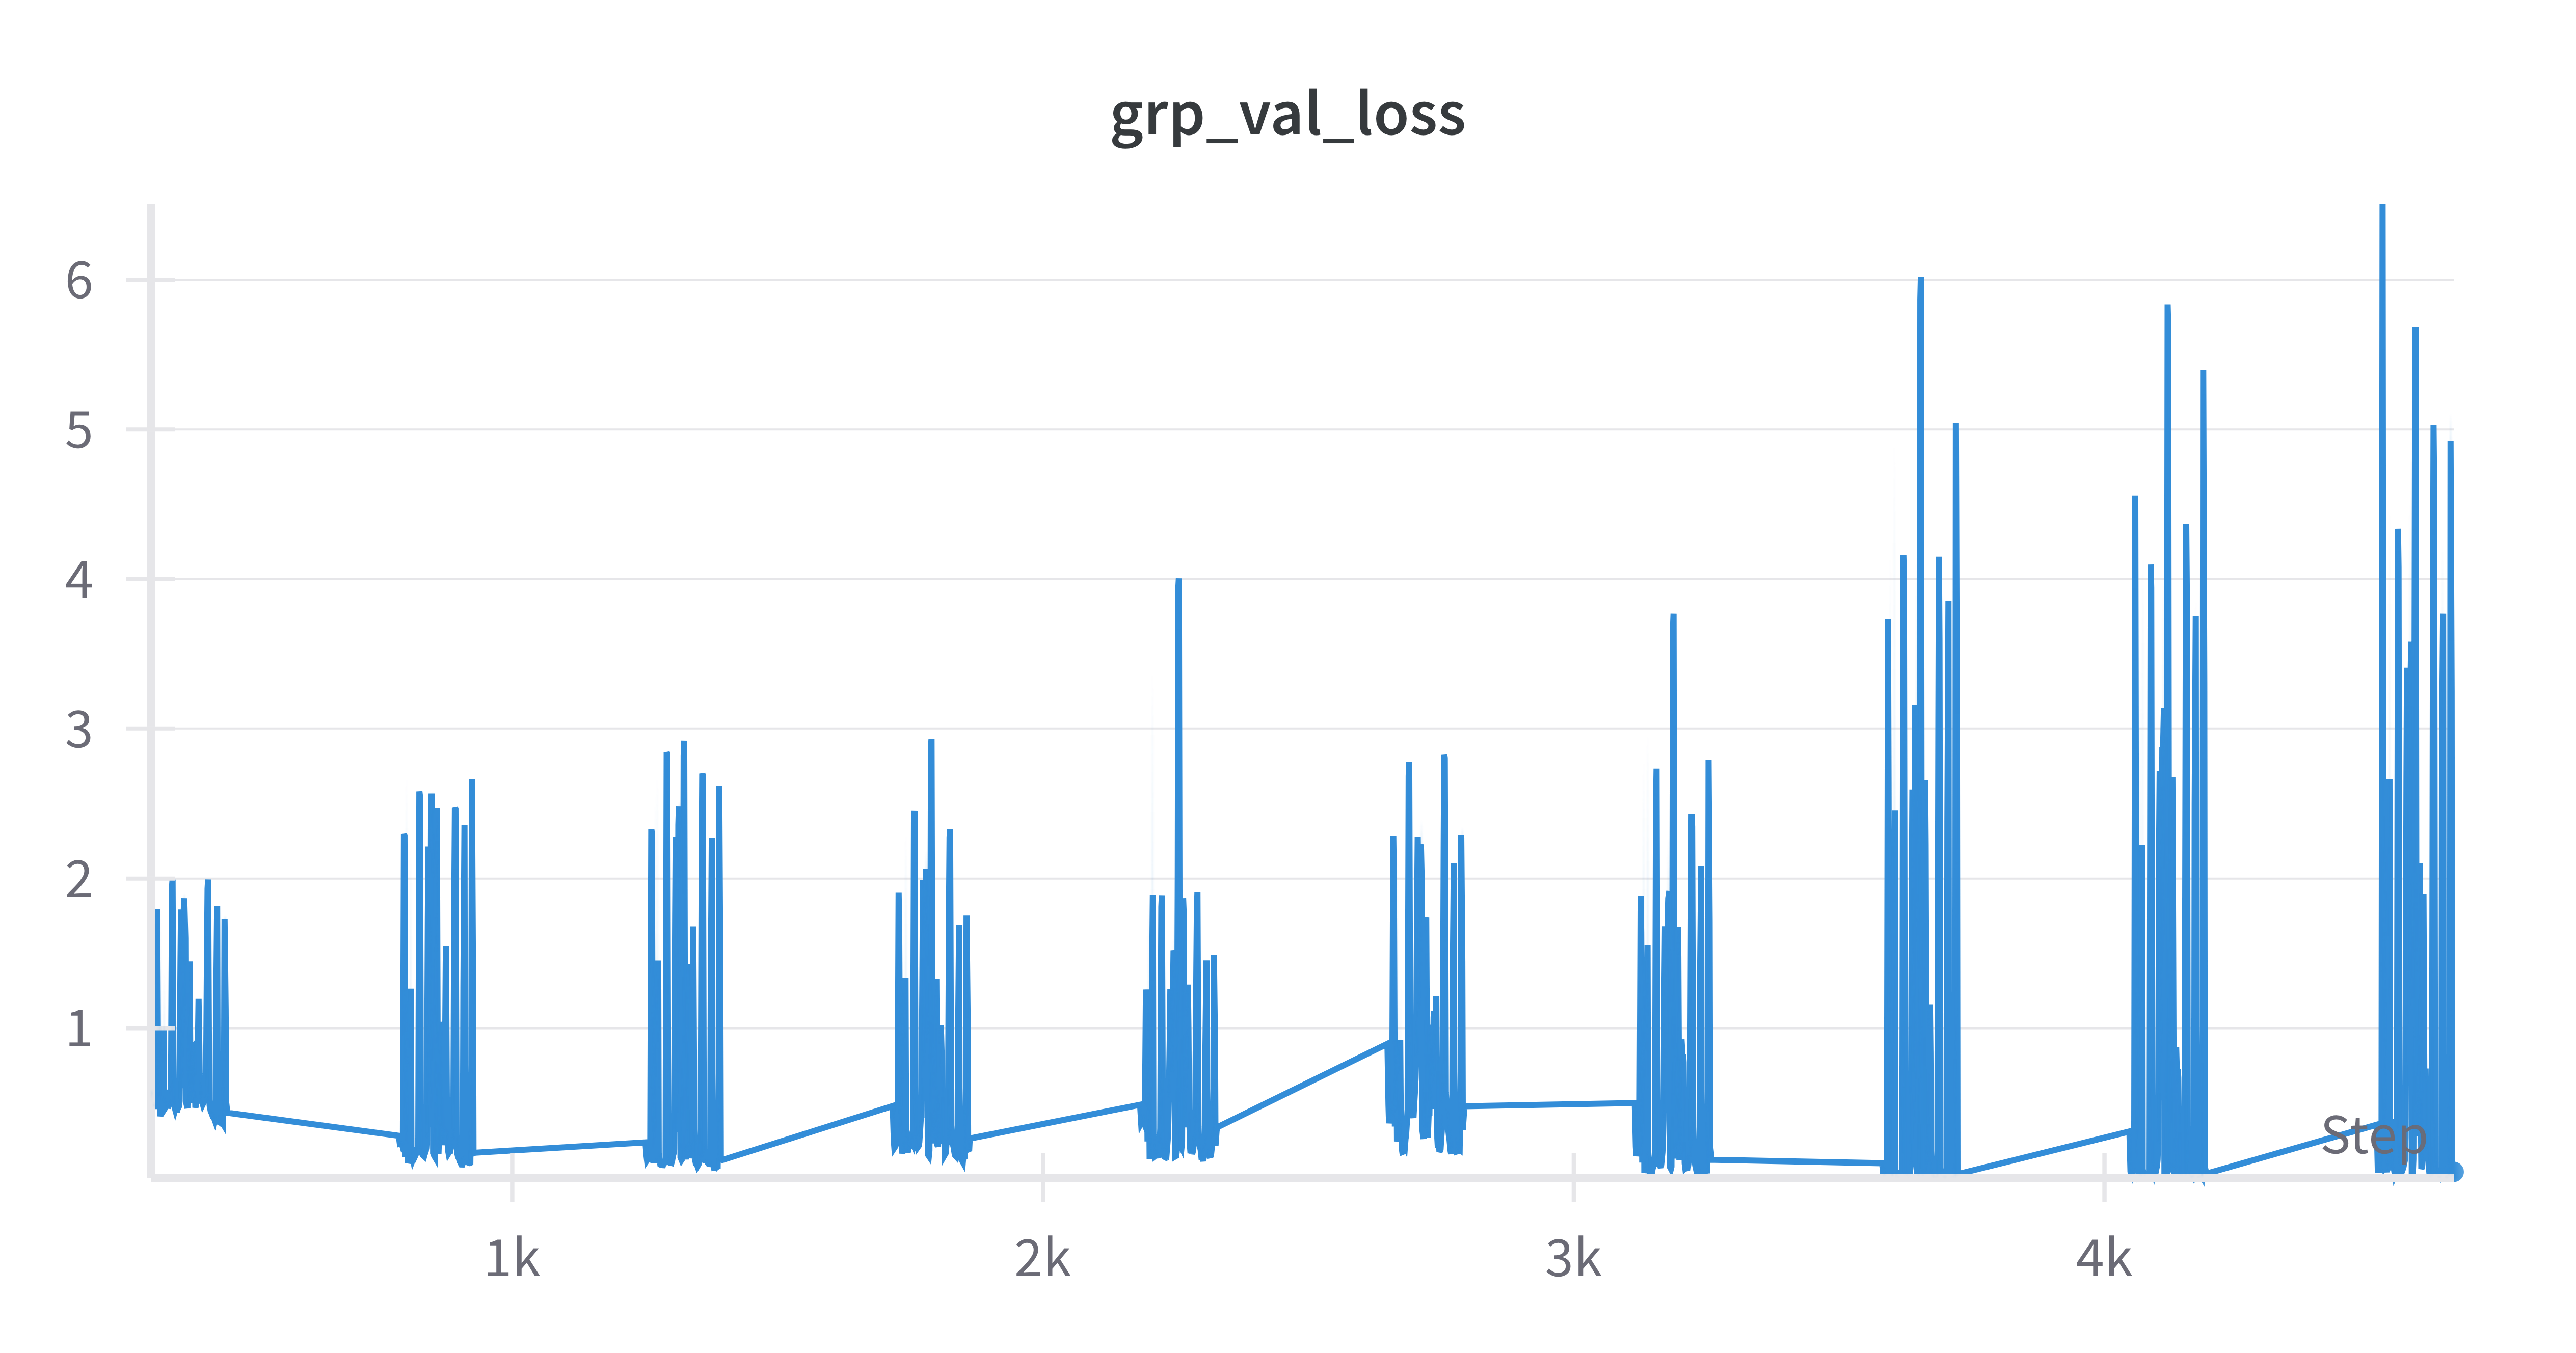

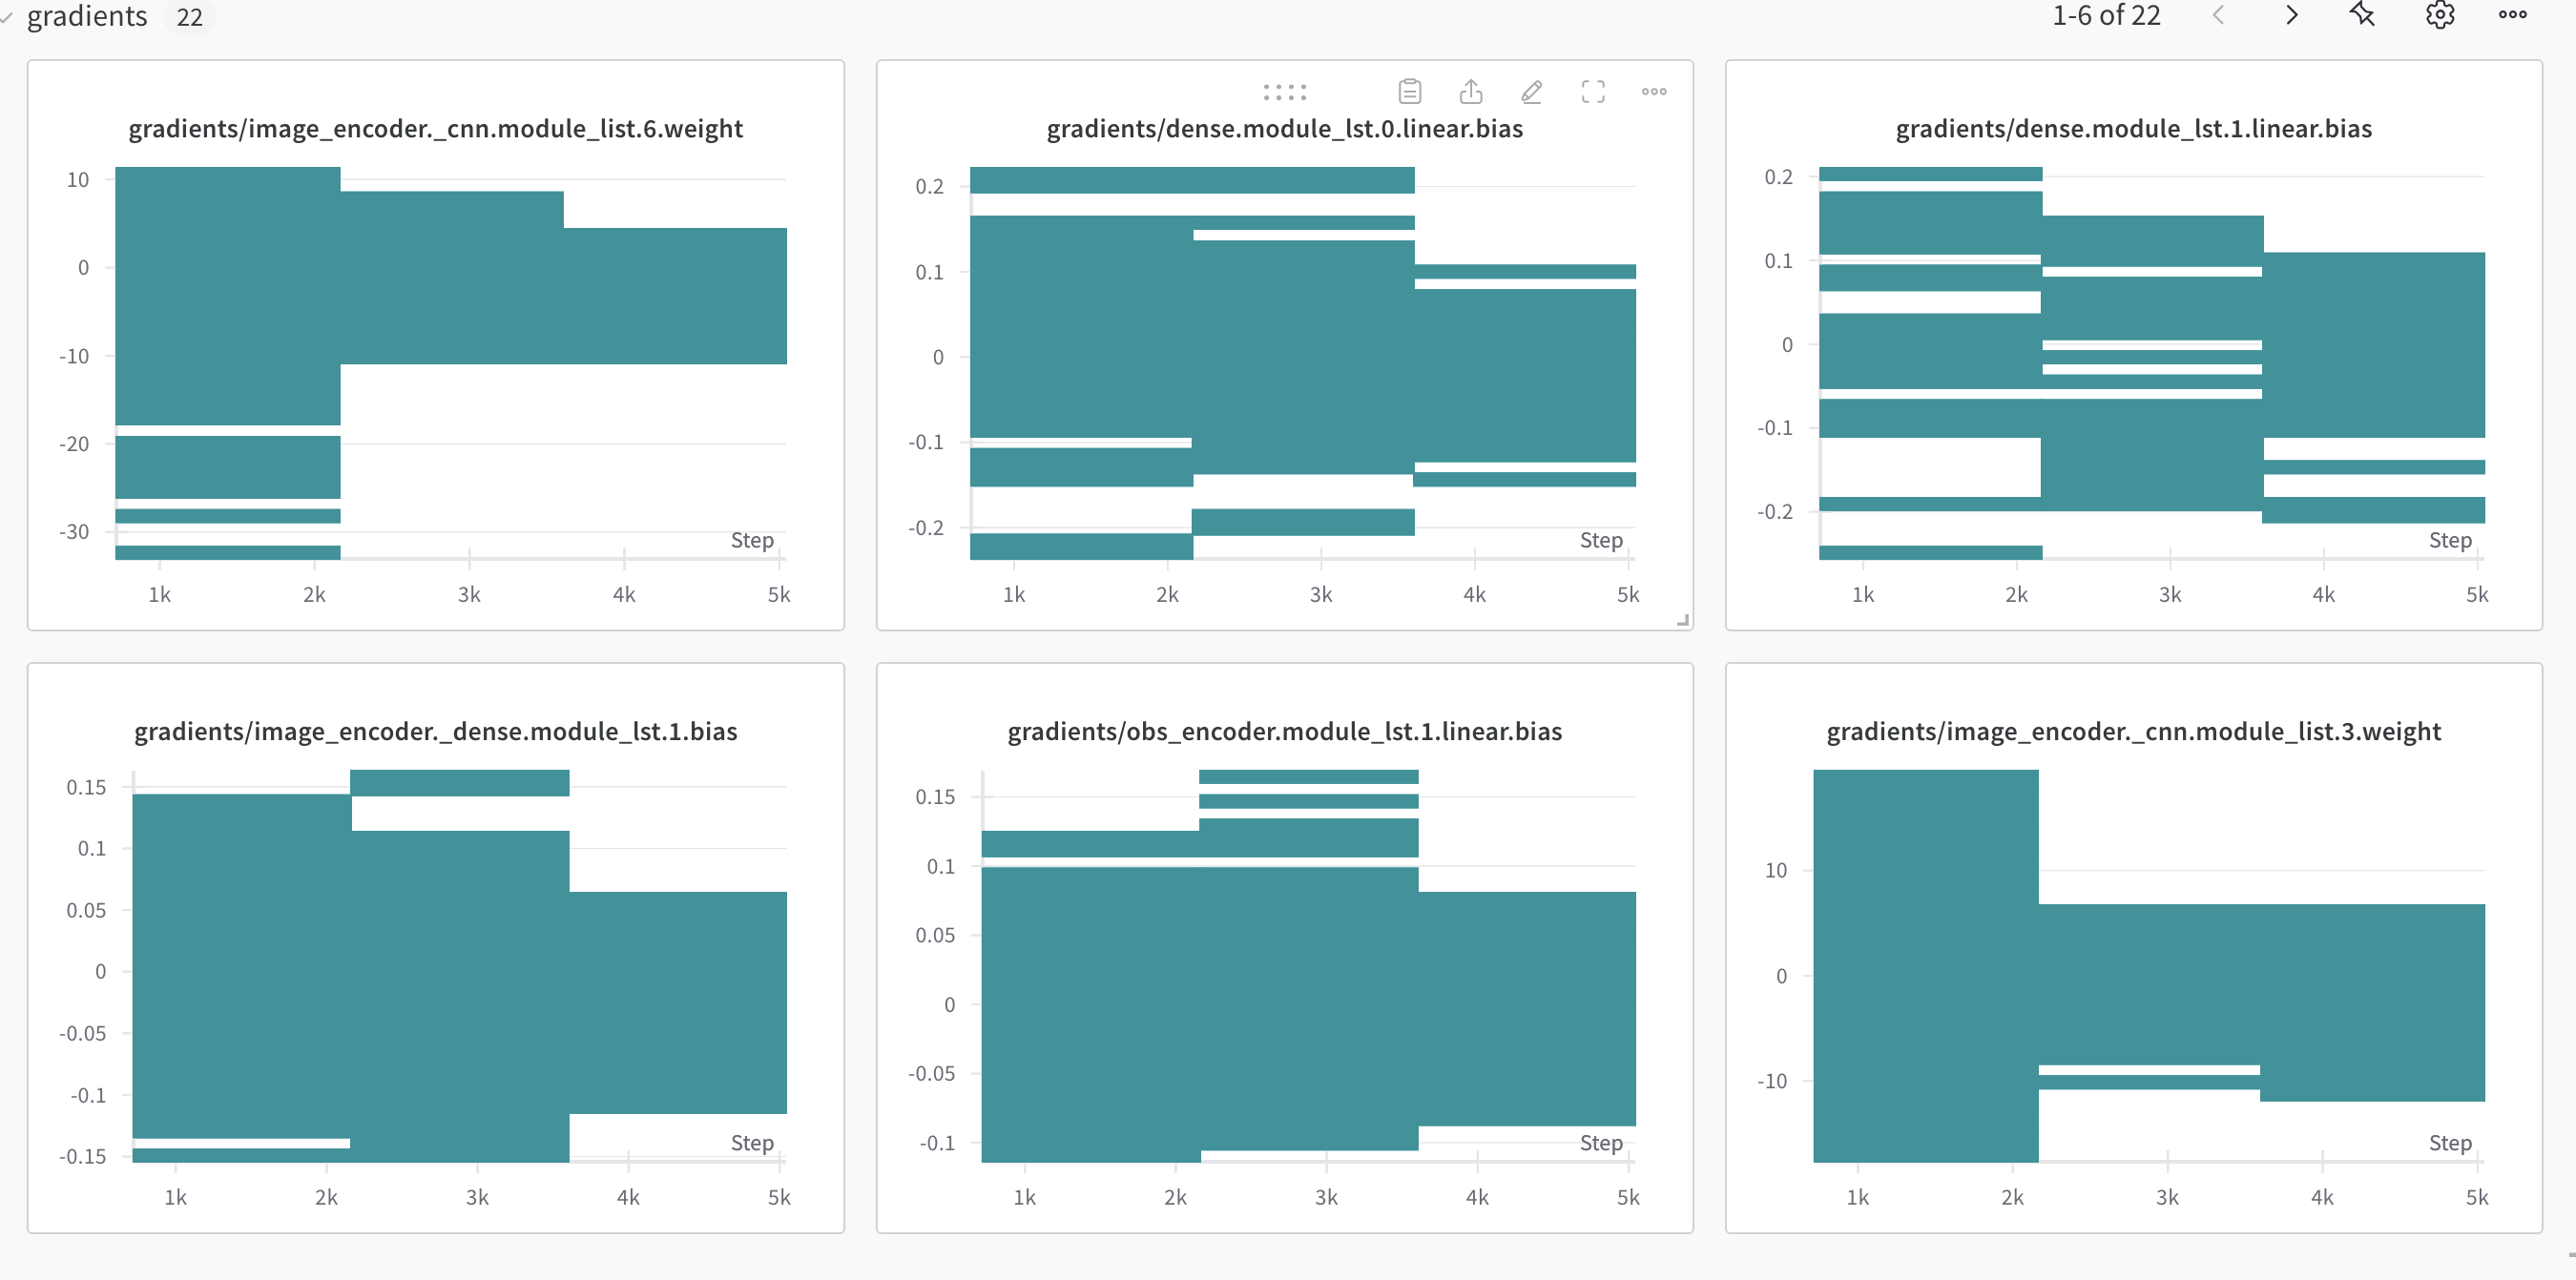

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description: Adding batch normalisation layers


##### Justification: Batch normalisation also solves the problem of big gradients as well as prevents overfitting at an early stage.


##### Conclusion: As compared to the base model, the gradient for model with batch normalisation are smaller right from the start(0-4) the whole time. Also from the image of validation loss, it is also smaller compared to base model and slower convergence. While the batch normalization does make the validation loss fluctuates around 0.7, from step 30k, this also improves the generalization ability of the model.

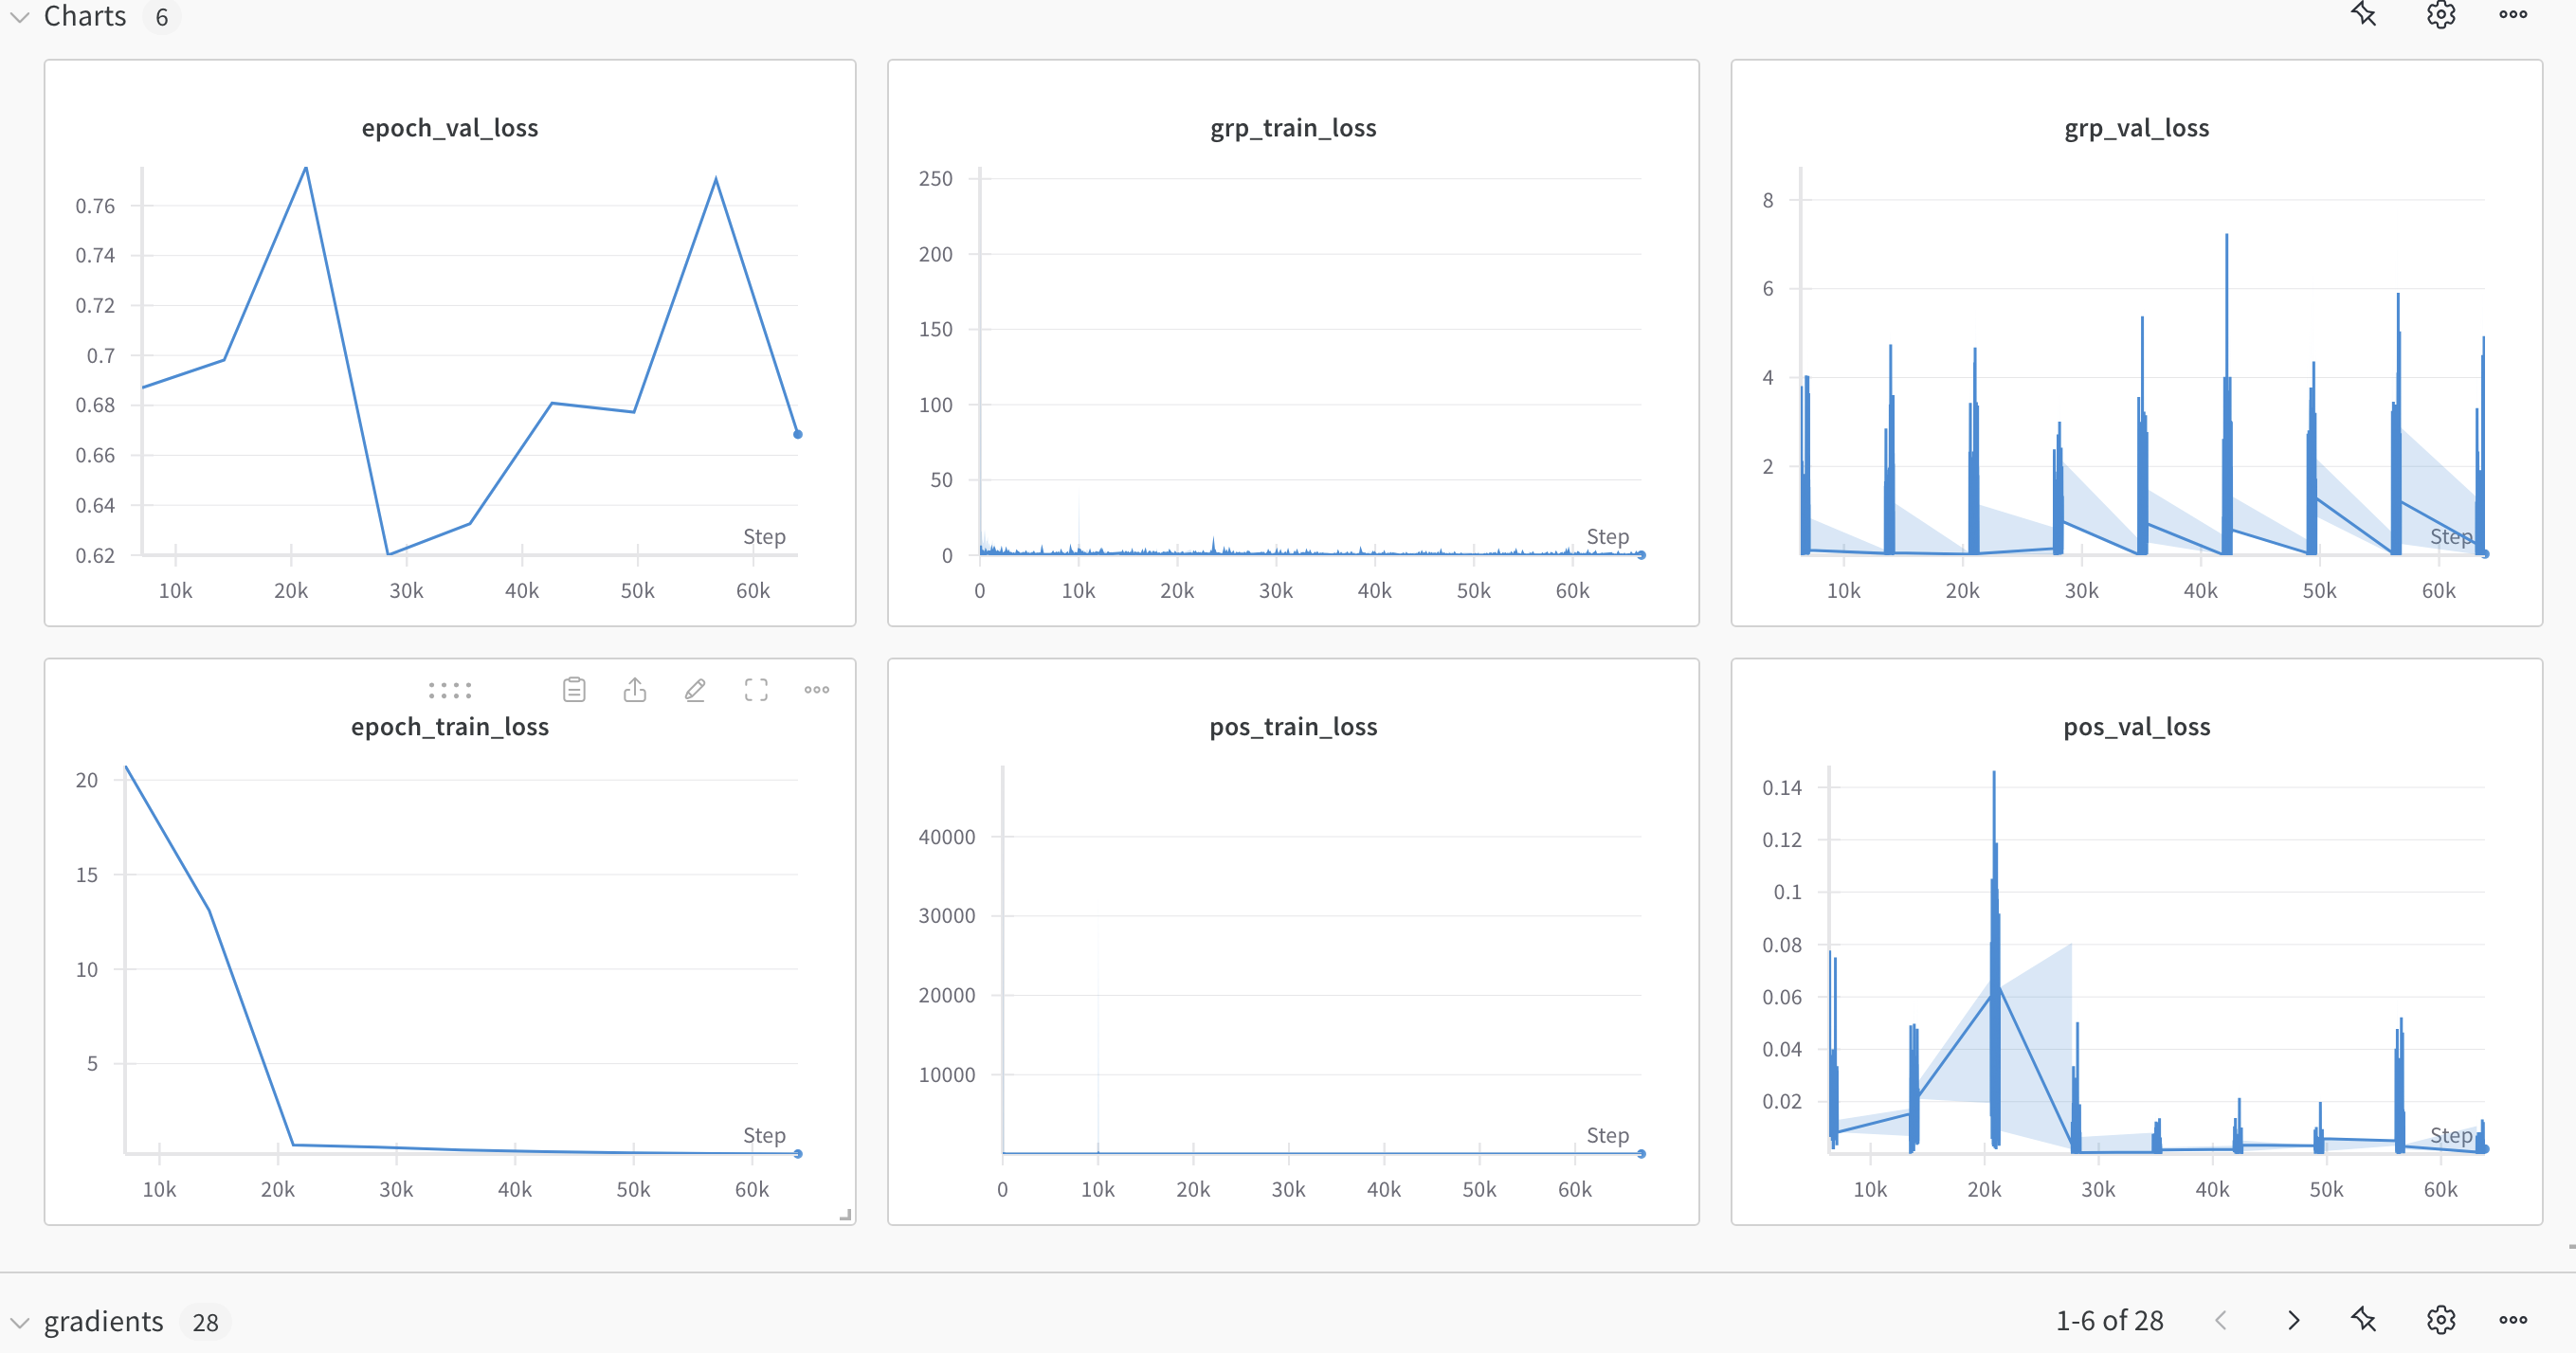

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
def collate_function(input_list: List[DatasetOutput]) -> DatasetOutput:

    return DatasetOutput(
        input={
            "front_images_ob": torch.stack([x.input["front_cam_ob"] for x in input_list], dim=0),
            "mount_images_ob": torch.stack([x.input["mount_cam_ob"] for x in input_list], dim=0),
            "pos_obs": torch.stack([x.input["ee_cartesian_pos_ob"] for x in input_list], dim=0),
            "vel_obs": torch.stack([x.input["ee_cartesian_vel_ob"] for x in input_list], dim=0),
            "joint_obs": torch.stack([x.input["joint_pos_ob"] for x in input_list], dim=0),
        },
        output={}
    )


In [ ]:
train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = [],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=0
        )

val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = [],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=0
        )
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_function, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_function, shuffle=False)

Image shape: torch.Size([32, 1, 224, 224]), range: 0.0023437500931322575 to 0.9779411554336548


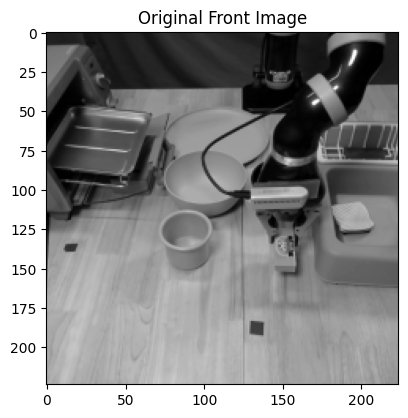

In [ ]:
import matplotlib.pyplot as plt
# Get a real training sample
for batch in val_loader:
    img_front, img_mount, pos, vel, joint =  batch.input["front_images_ob"], batch.input["mount_images_ob"], batch.input["pos_obs"], batch.input["vel_obs"], batch.input["joint_obs"]

    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(img_front[0, 0].cpu().numpy(),cmap="gray")
    plt.title("Original Front Image")
    print(f"Image shape: {img_front.shape}, range: {img_front.min()} to {img_front.max()}")
    break


In [ ]:
# ******* INSERT YOUR CODE HERE *******
class VAE_Encoder(nn.Module):
    def __init__(self, vector_latent_dim, latent_dim):
        super(VAE_Encoder, self).__init__()
        # CNNs for images
        self.image_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8,kernel_size=(3, 3),stride=1,padding=1,dilation=1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d( in_channels=8,out_channels=16,kernel_size=(3, 3), stride=1,padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3, 3),stride=1, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3, 3),stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        # MLPs for vectors
        self.vector_mlp1 = nn.Sequential(
            nn.Linear(7, 128),
            nn.ReLU(),
            nn.Linear(128, vector_latent_dim)
        )
        self.vector_mlp2 = nn.Sequential(
            nn.Linear(6, 128),
            nn.ReLU(),
            nn.Linear(128, vector_latent_dim)
        )
        self.vector_mlp3 = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, vector_latent_dim)
        )

        # Combine all embeddings
        cnn_output_size = self.image_cnn(torch.randn(1, 1, 224, 224)).view(1, -1).shape[1]
        combined_dim = 2 * cnn_output_size + 3 * vector_latent_dim
        self.image_latent_dim = cnn_output_size
        self.fc_mu = nn.Linear(combined_dim, latent_dim)
        self.fc_logvar = nn.Linear(combined_dim, latent_dim)

    def forward(self, img_front, img_mount, pos_ob, vel_ob, joint_ob):
        front_latent = self.image_cnn(img_front).view(img_front.size(0), -1)
        mount_latent = self.image_cnn(img_mount).view(img_mount.size(0), -1)
        pos_latent = self.vector_mlp1(pos_ob)
        vel_latent = self.vector_mlp2(vel_ob)
        joint_latent = self.vector_mlp3(joint_ob)

        combined = torch.cat([front_latent, mount_latent, pos_latent, vel_latent, joint_latent], dim=-1)
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar


#  sample from normal dis to get z
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)  # Sample from N(0, 1)
    return mu + eps * std

# decoder train a mapping from z to x and get x_pred
class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim, image_latent_dim, channels, height, width ,vector_latent_dim):
        super(VAE_Decoder, self).__init__()
        self.image_latent_dim = image_latent_dim
        self.vector_latent_dim = vector_latent_dim
        self.channels = channels
        self.height = height
        self.width = width
        # Fully connected layers to map z back to combined latent space
        self.fc = nn.Linear(latent_dim, 2 * (channels * height * width) + 3 * vector_latent_dim )

        # Decoders for images
        self.image_decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=32, out_channels= 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ConvTranspose2d(
                in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=8 , out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.Sigmoid()  # Use sigmoid to scale pixel values to [0, 1]
        )

        # Decoders for vectors
        self.vector_decoder1 = nn.Sequential(
            nn.Linear(vector_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 7)  # Output size matches original pos_ob
        )
        self.vector_decoder2 = nn.Sequential(
            nn.Linear(vector_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 6)  # Output size matches original vel_ob
        )
        self.vector_decoder3 = nn.Sequential(
            nn.Linear(vector_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output size matches original joint_ob
        )

    def forward(self, z):
        vector_latent_dim = self.vector_latent_dim
        # Map latent vector z back to combined latent space
        combined_latent = self.fc(z)
        assert combined_latent.shape[-1] == 2 * (self.channels * self.height * self.width) + 3 * vector_latent_dim, \
    f"Expected {2 * (self.channels * self.height * self.width) + 3 * vector_latent_dim}, got {combined_latent.shape[-1]}"

        # Split combined latent space into components
        front_latent, mount_latent, pos_latent, vel_latent, joint_latent = torch.split(
            combined_latent, [ self.image_latent_dim,  self.image_latent_dim, vector_latent_dim, vector_latent_dim, vector_latent_dim], dim=-1
        )

        # Decode each component
        recon_img_front = self.image_decoder(front_latent.view(-1, self.channels , self.height , self.width))  # Reshape for deconvolution
        recon_img_mount = self.image_decoder(mount_latent.view(-1, self.channels , self.height , self.width))
        recon_pos_ob = self.vector_decoder1(pos_latent)
        recon_vel_ob = self.vector_decoder2(vel_latent)
        recon_joint_ob = self.vector_decoder3(joint_latent)

        return recon_img_front, recon_img_mount, recon_pos_ob, recon_vel_ob, recon_joint_ob



# use use mse and kl to have loss
class VAE(nn.Module):
    def __init__(self,  vector_latent_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(vector_latent_dim, latent_dim)
        image_latent_dim = self.encoder.image_latent_dim

        cnn_output_size = self.encoder.image_cnn(torch.randn(1, 1, 224, 224)).shape  # (1, channels, height, width)
        print(f"Encoder CNN output size: {cnn_output_size}")

        initial_channels = cnn_output_size[1]
        initial_height = cnn_output_size[2]
        initial_width = cnn_output_size[3]
        print(f"Channels: {initial_channels}, Height: {initial_height}, Width: {initial_width}")
        print(f"Computed image_latent_dim: {image_latent_dim}")

        self.decoder = VAE_Decoder(latent_dim, image_latent_dim, initial_channels, initial_height, initial_width, vector_latent_dim)

    def forward(self, img_front, img_mount, pos, vel, joint):
        mu, logvar = self.encoder(img_front, img_mount, pos, vel, joint)
        print(f"Mean of mu: {mu.mean().item()}, Std of logvar: {logvar.exp().mean().item()}")
        z = reparameterize(mu, logvar)
        recon_front, recon_mount, recon_pos, recon_vel, recon_joint = self.decoder(z)
        return recon_front, recon_mount, recon_pos, recon_vel, recon_joint, mu, logvar


def vae_loss(recon_img_front, img_front, recon_img_mount, img_mount, recon_pos, pos, recon_vel, vel, recon_joint, joint, mu, logvar):
    # Reconstruction Loss
    recon_loss = (
        F.mse_loss(recon_img_front, img_front, reduction='mean') +
        F.mse_loss(recon_img_mount, img_mount, reduction='mean') +
        F.mse_loss(recon_pos, pos, reduction='sum') +
        F.mse_loss(recon_vel, vel, reduction='sum') +
        F.mse_loss(recon_joint, joint, reduction='sum')
    )

    # KL Divergence Loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss_rescaled = kl_loss / latent_dim

    return recon_loss, kl_loss_rescaled


# ******* INSERT YOUR CODE HERE - END *******

In [ ]:
def validate(
    vae,  # VAE model
    val_loader,  # DataLoader for validation
    scheduler,  # Learning rate scheduler
    device,  # Device (e.g., "cuda" or "cpu")
    beta,
    epoch,
    log_to_wandb=True, # Option to log metrics to Weights & Biases

):
    vae.eval()  # Set model to evaluation mode
    total_recon_loss = 0
    total_kl_loss = 0
    total_loss = 0

    with torch.no_grad():  # No gradient computation during validation
        for batch in val_loader:
            # Access individual inputs
            front_images = batch.input["front_images_ob"]
            mount_images = batch.input["mount_images_ob"]
            pos_obs = batch.input["pos_obs"]
            vel_obs = batch.input["vel_obs"]
            joint_obs = batch.input["joint_obs"]

            # Move to device
            front_images, mount_images, pos_obs, vel_obs, joint_obs = (
                front_images.to(device),
                mount_images.to(device),
                pos_obs.to(device),
                vel_obs.to(device),
                joint_obs.to(device),
            )

            # Forward pass
            mu, logvar = vae.encoder(front_images, mount_images, pos_obs, vel_obs, joint_obs)
            z = reparameterize(mu, logvar)
            recon_front_images, recon_mount_images, recon_pos_obs, recon_vel_obs, recon_joint_obs = vae.decoder(z)

            # Compute loss
            recon_loss, kl_loss = vae_loss(
                recon_front_images, front_images,
                recon_mount_images, mount_images,
                recon_pos_obs, pos_obs,
                recon_vel_obs, vel_obs,
                recon_joint_obs, joint_obs,
                mu, logvar
            )

            loss = recon_loss + beta * kl_loss

            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()


    # Compute averages
    avg_recon_loss = total_recon_loss / len(val_loader)
    avg_kl_loss = total_kl_loss / len(val_loader)
    avg_total_loss = total_loss / len(val_loader)
    # Step the scheduler with validation loss
    scheduler.step(avg_total_loss)

    # Log validation metrics
    if log_to_wandb:
        wandb.log({
            "val_reconstruction_loss": avg_recon_loss,
            "val_kl_divergence": avg_kl_loss,
            "val_total_loss": avg_total_loss,
            "learning_rate": optimizer.param_groups[0]["lr"]
        })
    print(f"Validation Results - Reconstruction Loss: {avg_recon_loss:.4f}, KL Divergence: {avg_kl_loss:.4f}, Total Loss: {avg_total_loss:.4f}")

    return avg_recon_loss, avg_kl_loss, avg_total_loss


In [ ]:
def trainloop(
    vae,  # VAE model
    train_loader,  # DataLoader for training
    optimizer,  # Optimizer (e.g., Adam)
    device,  # Device (e.g., "cuda" or "cpu")
    epoch,
    beta
):

    vae.train()  # Set model to training mode
    reconstruction = {"re_front" : [],"re_mount":[] ,"re_pos" :[], "re_vel" :[], "re_joint" :[],
                      "original_front":[],"original_mount":[],"original_pos":[], "original_vel":[], "original_joint":[]}

    total_loss = 0
    # this is for choosing batch to store into reconstruction
    count = 0

    for batch in train_loader:
        count += 1
        # Access individual inputs
        front_images = batch.input["front_images_ob"]
        mount_images = batch.input["mount_images_ob"]
        pos_obs = batch.input["pos_obs"]
        vel_obs = batch.input["vel_obs"]
        joint_obs = batch.input["joint_obs"]
        # Move to device
        front_images, mount_images, pos_obs, vel_obs, joint_obs = (
            front_images.to(device),
            mount_images.to(device),
            pos_obs.to(device),
            vel_obs.to(device),
            joint_obs.to(device),
        )

        # Forward pass
        mu, logvar = vae.encoder(front_images, mount_images, pos_obs, vel_obs, joint_obs)
        logvar = torch.clamp(logvar, min=-3.0, max=2.0)  # Keep variance in a reasonable range
        z = reparameterize(mu, logvar)
        recon_front_images, recon_mount_images, recon_pos_obs, recon_vel_obs, recon_joint_obs = vae.decoder(z)
        if count % 10 == 0:
            # print(f"The reconstruction in batch {count} saved ")
            reconstruction["re_front"].append(recon_front_images)
            reconstruction["re_mount"].append(recon_mount_images)
            reconstruction["re_pos"].append(recon_pos_obs)
            reconstruction["re_vel"].append(recon_vel_obs)
            reconstruction["re_joint"].append(recon_joint_obs)
            reconstruction["original_front"].append(front_images)
            reconstruction["original_mount"].append(mount_images)
            reconstruction["original_pos"].append(pos_obs)
            reconstruction["original_vel"].append(vel_obs)
            reconstruction["original_joint"].append(joint_obs)

        # Compute loss
        recon_loss, kl_loss = vae_loss(
            recon_front_images, front_images,
            recon_mount_images, mount_images,
            recon_pos_obs, pos_obs,
            recon_vel_obs, vel_obs,
            recon_joint_obs, joint_obs,
            mu, logvar
        )

        loss = recon_loss + beta * kl_loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

        # Log batch-level metrics
        wandb.log({
                "batch_reconstruction_loss": recon_loss.item(),
                "batch_kl_divergence": kl_loss.item(),
                "batch_total_loss": loss.item()
            })

    # Log epoch-level metrics
    avg_epoch_loss = total_loss / len(train_loader)
    wandb.log({"epoch_total_loss": avg_epoch_loss})

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}, Recon loss: {recon_loss:.4f}, KL: {kl_loss:.4f}")


    return avg_epoch_loss, reconstruction


In [ ]:
def test_dimension():
  batch_size = 32
  img_front = torch.randn(batch_size, 1, 224, 224)
  img_mount = torch.randn(batch_size, 1, 224, 224)
  pos = torch.randn(batch_size, 7)
  vel = torch.randn(batch_size, 6)
  joint = torch.randn(batch_size, 2)

  vae = VAE(vector_latent_dim=64, latent_dim=128)
  recon_front, recon_mount, recon_pos, recon_vel, recon_joint, mu, logvar = vae(img_front, img_mount, pos, vel, joint)
  print(recon_front.shape, recon_mount.shape, recon_pos.shape, recon_vel.shape, recon_joint.shape)


In [ ]:
import math

def kl_annealing(epoch, total_epochs,warmup_epochs=5, max_beta=1.0):
    if epoch < warmup_epochs:
        return 0.01
    return min(max_beta, epoch / (total_epochs / 2))


def train_and_validate_loop(vae, train_loader, val_loader, optimizer,scheduler, num_epochs, device, beta):

    for epoch in range(num_epochs):
        beta = kl_annealing(epoch, num_epochs,2 , beta)
        # Training loop
        train_loss, reconstruction = trainloop(vae, train_loader, optimizer, device, epoch, beta)

        # Validation loop
        _,_, val_loss = validate(vae, val_loader, scheduler, device, beta, True)

        # Log epoch metrics
        wandb.log({"Average epoch_train_loss": train_loss, "Average epoch_val_loss": val_loss})

    return reconstruction

In [ ]:
import wandb

num_epochs = 10
# Initialize the VAE model
vector_latent_dim = 16  # Latent size for vector
latent_dim = 32   # Global latent size for VAE
vae = VAE(vector_latent_dim, latent_dim)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

# Define optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=2e-3, weight_decay =1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
beta = 0.1

wandb.init(project="vae_robot_behavior", name="vae_training_run")
reconstructed = train_and_validate_loop(vae, train_loader, val_loader, optimizer, scheduler, num_epochs, device, beta)
wandb.finish()

Encoder CNN output size: torch.Size([1, 64, 14, 14])
Channels: 64, Height: 14, Width: 14
Computed image_latent_dim: 12544


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch [1/10], Average Loss: 5.6277, Recon loss: 9.3587, KL: 49.3791
Validation Results - Reconstruction Loss: 1.5005, KL Divergence: 72.5275, Total Loss: 2.2258
Epoch [2/10], Average Loss: 2.3683, Recon loss: 1.1479, KL: 36.2189
Validation Results - Reconstruction Loss: 0.7415, KL Divergence: 87.2668, Total Loss: 1.6142
Epoch [3/10], Average Loss: 2.3543, Recon loss: 0.4314, KL: 30.2587
Validation Results - Reconstruction Loss: 0.4742, KL Divergence: 56.5654, Total Loss: 1.0398
Epoch [4/10], Average Loss: 1.4687, Recon loss: 0.5434, KL: 31.9675
Validation Results - Reconstruction Loss: 0.4855, KL Divergence: 40.0628, Total Loss: 0.8861
Epoch [5/10], Average Loss: 1.6772, Recon loss: 0.5238, KL: 28.5052
Validation Results - Reconstruction Loss: 0.5965, KL Divergence: 35.5167, Total Loss: 0.9517
Epoch [6/10], Average Loss: 1.2947, Recon loss: 0.6546, KL: 26.3686
Validation Results - Reconstruction Loss: 0.5695, KL Divergence: 40.6135, Total Loss: 0.9756
Epoch [7/10], Average Loss: 2.5504

Mean of mu: -0.027035459876060486, Std of logvar: 0.3314549922943115


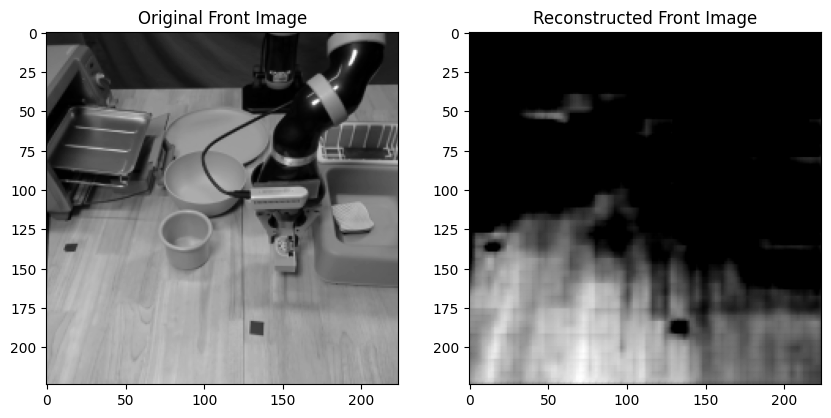

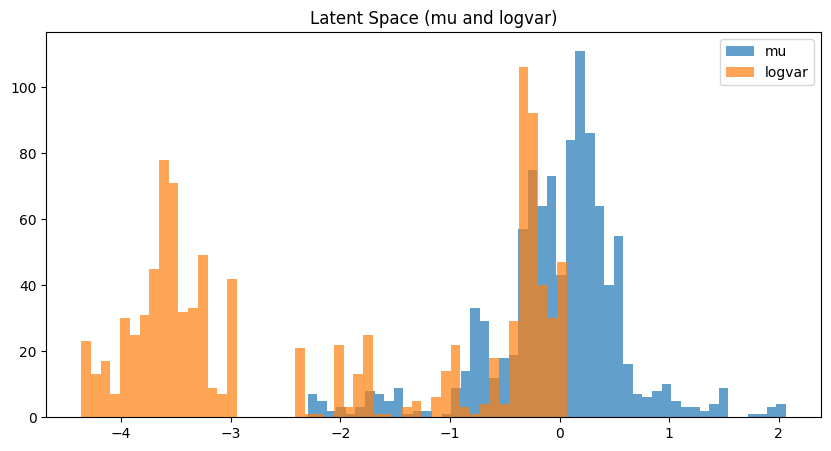

In [ ]:
import matplotlib.pyplot as plt
# Get a real training sample
for batch in val_loader:
    img_front, img_mount, pos, vel, joint =  batch.input["front_images_ob"], batch.input["mount_images_ob"], batch.input["pos_obs"], batch.input["vel_obs"], batch.input["joint_obs"]
    img_front, img_mount = img_front.to(device), img_mount.to(device)
    pos, vel, joint = pos.to(device), vel.to(device), joint.to(device)

    vae.eval()
    with torch.no_grad():
        mu, logvar = vae.encoder(img_front, img_mount, pos, vel, joint)
        z = reparameterize(mu,logvar)
        # print(f"mu is {mu}")
        # print(f"logvar is {logvar}")
        recon_front, recon_mount, recon_pos, recon_vel, recon_joint, mu, logvar = vae(
            img_front, img_mount, pos, vel, joint
        )

        plt.figure(figsize=(10, 5))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img_front[0, 0].cpu().numpy(), cmap="gray")
        plt.title("Original Front Image")

        # Reconstructed Image
        plt.subplot(1, 2, 2)
        plt.imshow(recon_front[0, 0].cpu().numpy(), cmap="gray")
        plt.title("Reconstructed Front Image")


        plt.figure(figsize=(10, 5))
        plt.hist(mu.cpu().numpy().flatten(), bins=50, alpha=0.7, label='mu')
        plt.hist(logvar.cpu().numpy().flatten(), bins=50, alpha=0.7, label='logvar')
        plt.legend()
        plt.title("Latent Space (mu and logvar)")
        plt.show()


    break


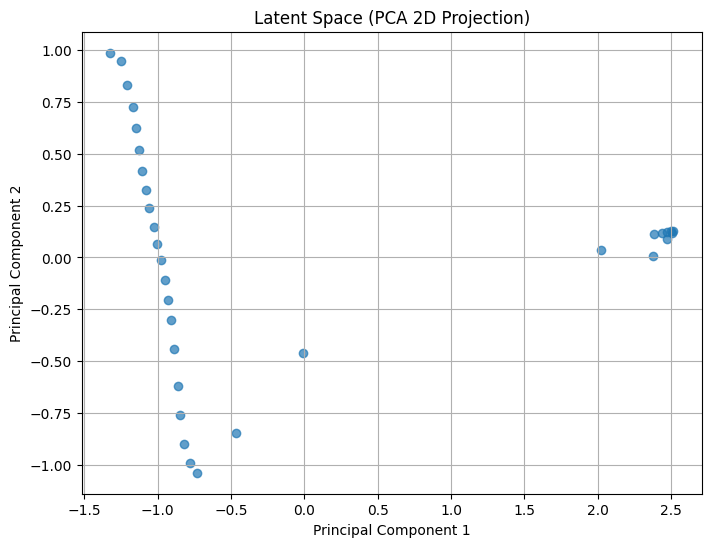

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latents =[]
latents.append(mu.cpu().numpy())
latents = np.concatenate(latents, axis=0)  # Shape: [num_samples, latent_dim]
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
plt.title("Latent Space (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()



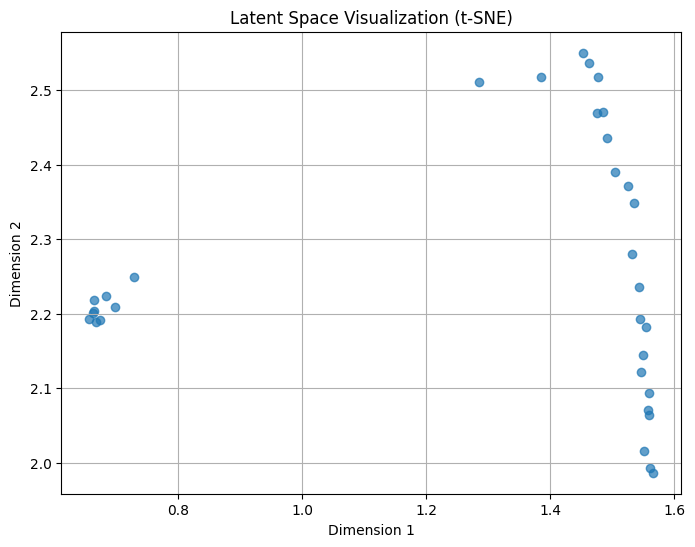

In [ ]:
from sklearn.manifold import TSNE


# Visualize latent space
latent_2d_tsne = TSNE(n_components=2).fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], alpha=0.7)
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()




### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

### Q2b Model Convergence Answer:
The training and validation metrics indicate that the model has converged. The training loss consistently decreases from 5.55 to 0.74, and the validation reconstruction loss drops to 0.27 by Epoch 20. The KL divergence stabilizes, suggesting that the latent space has meaningful structure. While there are spikes in KL divergence during some epochs (e.g., Epoch 13 and 14), the overall trend shows convergence.
At the start of the training, I used a smaller beta(0.001) so that the model focuses on reducing the reconstruction loss and in further epochs, beta gradually gets set to 0.1.

This techinique refered to KL annealling, helps solve the problem of latent space collapse. A learning rate scheduler is also deployed for more stable learning.

The model has converged because from epoch 15 and on, the reconstruction loss stabalized near 0.26 and 0.30, the network has satuated as there are limited latent dimensions.

Furthermore, visualizations of the reconstructed images and latent space support the claim that the model captures meaningful patterns in the data. These results demonstrate that the VAE is appropriately trained and capable of generating useful representations.

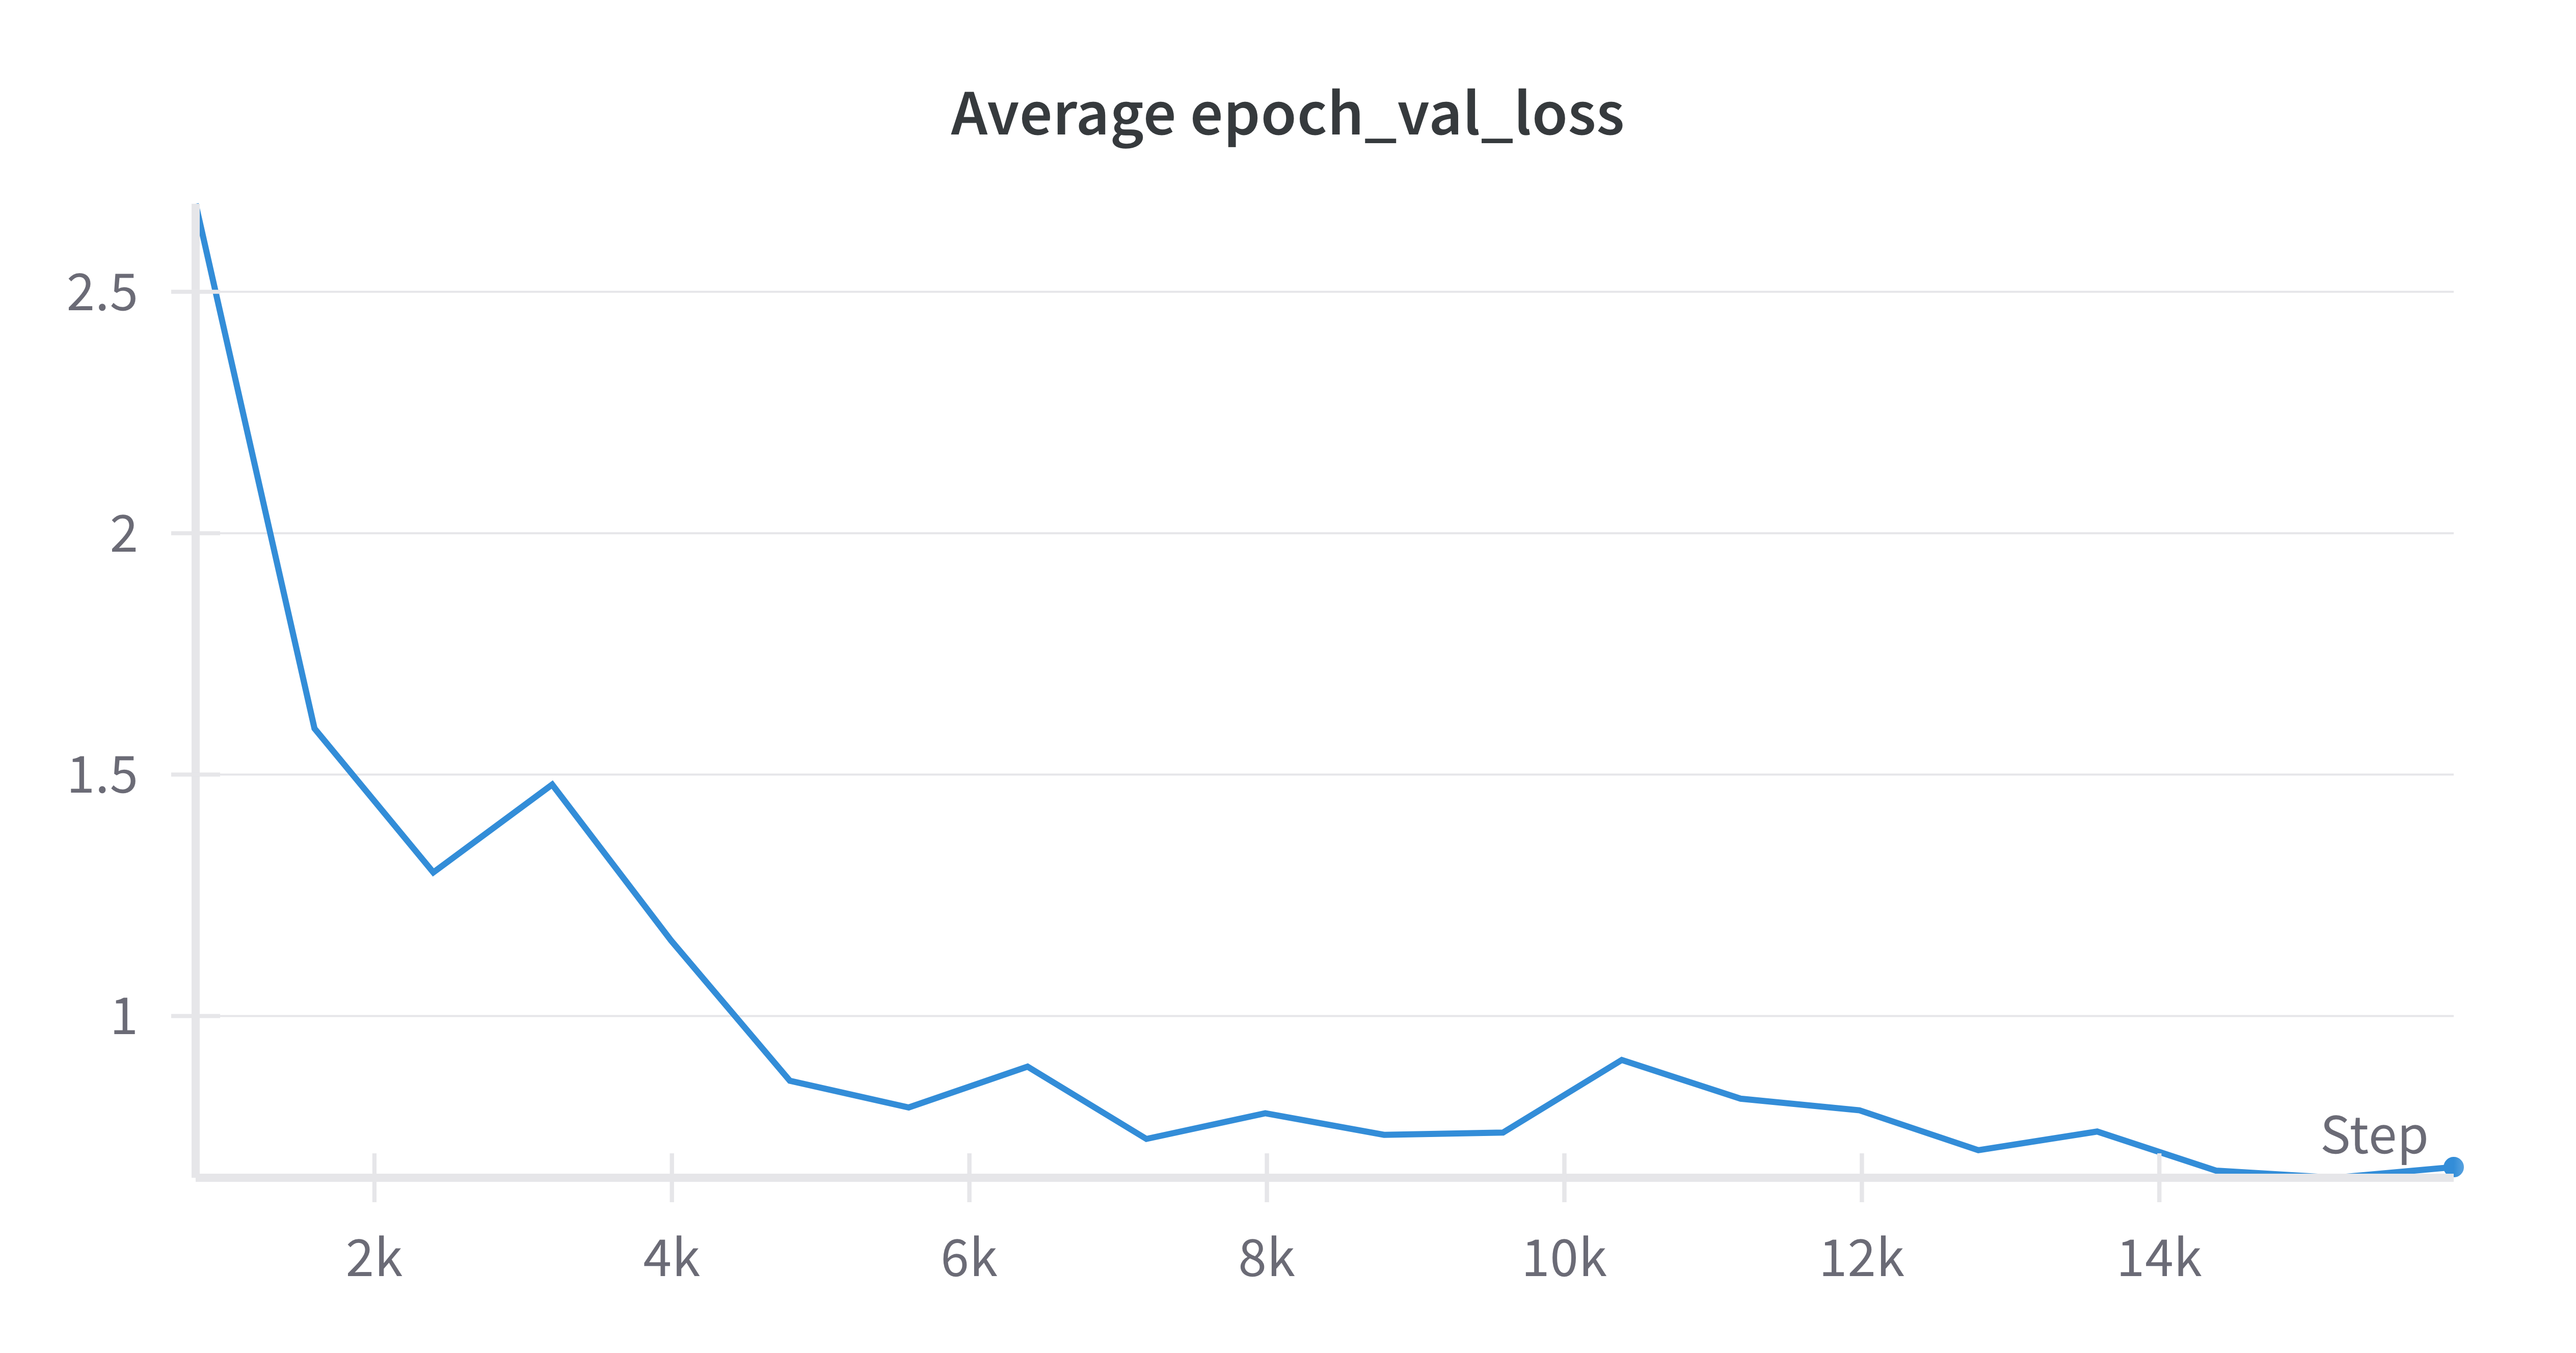

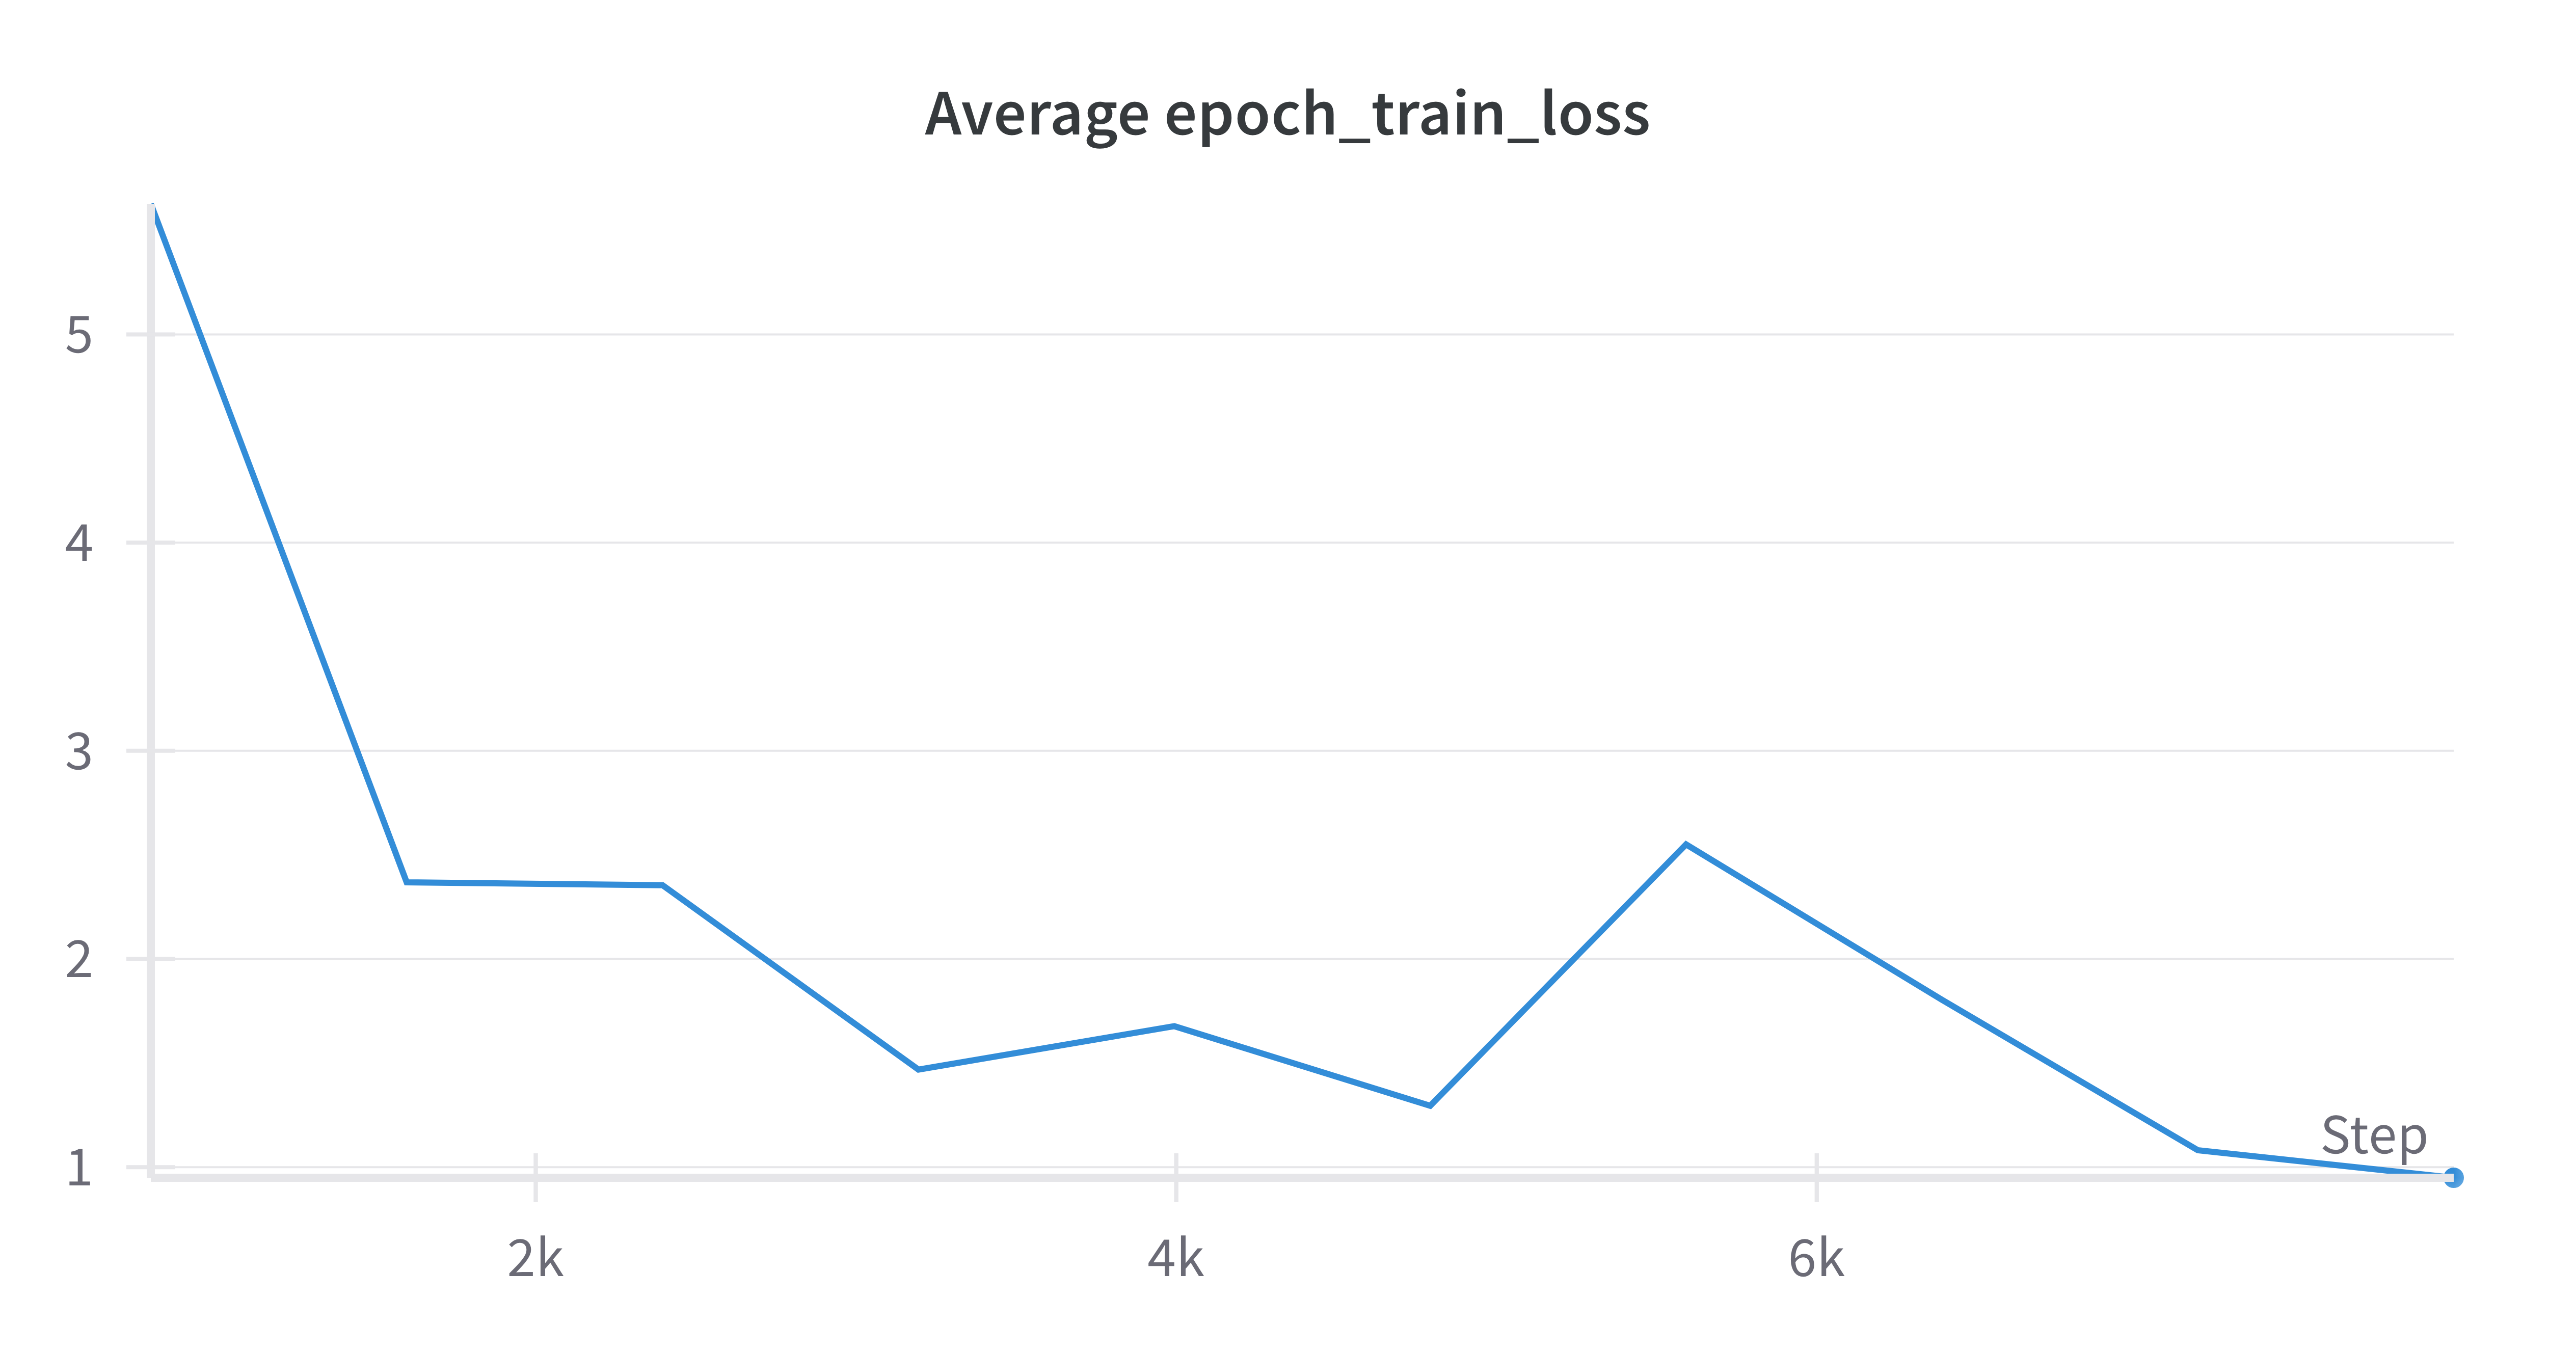

### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__.

### Answer 2.c Latent space analysis (6 marks)
From the above bar charts of how the latent space is formed, average mu is -0.02 and the standard deviation of  log variance is around 0.33. This means the KL regularizes the data well, therefore mu is near 0.  The logvar is not near 0 and this shows a compact latent space and have not collapsed.

Even though the distribution of mu is not bell shaped, but from comparing the reconstruction images and original images, the VAE has learnt some traits of the robot scene, the floor and were able to identify some objects which is black in the reconstruction.

From the PCA and TSNE, there were clear clustering, which shows the modelmodel's latent space is organizing data points in a way that reflects meaningful structure.

### Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [ ]:
exp_kwargs = {  # Define exp_kwargs here with the necessary parameters
    "batch_size": 32,
    "learning_rate": 0.01,
    "half_precision": False,
    "target_offset": 0
}

def collate_function(input_list: List[DatasetOutput]) -> DatasetOutput:
    # Rest of the collation logic
    pos = []
    _grp = []
    for val in input_list:
        pos.append(val.output["actions"][0:3][None, :])  # Extract position
        _grp.append(val.output["actions"][-1:][None])  # Extract grip state
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0], 3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1

    result = DatasetOutput(
        input={
            "front_images_ob": torch.stack([x.input["front_cam_ob"] for x in input_list], dim=0),
            "mount_images_ob": torch.stack([x.input["mount_cam_ob"] for x in input_list], dim=0),
            "pos_obs": torch.stack([x.input["ee_cartesian_pos_ob"] for x in input_list], dim=0),
            "vel_obs": torch.stack([x.input["ee_cartesian_vel_ob"] for x in input_list], dim=0),
            "joint_obs": torch.stack([x.input["joint_pos_ob"] for x in input_list], dim=0),
        },
        output={
            "pos": torch.concat(pos, dim=0),
            "grp": grp,
        }
    )
    return result


In [ ]:

# this loss function takes a balanced loss over pos and grip
def loss_balanced(pred, target):
    assert(pred['pos'].shape == target['pos'].shape)
    # mse for positions and grp loss is the grip loss
    pos_loss = nn.MSELoss()(pred["pos"], target["pos"])
    grp_loss = nn.BCEWithLogitsLoss()(pred["grp"], target["grp"])

    return pos_loss +  grp_loss



def train_model(model, train_loader, val_loader, optimizer, num_epochs,loss_fn, device):
    train_losses =[]
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        num_train_batches = 0

        # Training phase
        for batch in train_loader:
            #this is the inputs for the model
            img_front = batch.input["front_images_ob"].to(device)
            img_mount = batch.input["mount_images_ob"].to(device)
            pos_obs = batch.input["pos_obs"].to(device)
            vel_obs = batch.input["vel_obs"].to(device)
            joint_obs = batch.input["joint_obs"].to(device)
            # y (action[:3] and then one hot encoded)targets = batch.output
            targets = {key: value.to(device) for key, value in batch.output.items()}


            # Forward pass
            predictions = model(img_front,img_mount,pos_obs,vel_obs,joint_obs)

            # Compute loss
            loss = loss_fn(predictions, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            num_train_batches += 1
        # calculate the loss per epoch
        avg_train_loss = train_loss / num_train_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        num_val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                img_front = batch.input["front_images_ob"].to(device)
                img_mount = batch.input["mount_images_ob"].to(device)
                pos_obs = batch.input["pos_obs"].to(device)
                vel_obs = batch.input["vel_obs"].to(device)
                joint_obs = batch.input["joint_obs"].to(device)
                targets = {key: value.to(device) for key, value in batch.output.items()}

                predictions = model(img_front,img_mount,pos_obs,vel_obs,joint_obs)
                loss =loss_fn(predictions, targets)
                val_loss += loss.item()
                num_val_batches += 1
            # avg val loss per epoch
            avg_val_loss = val_loss / num_val_batches
            val_losses.append(avg_val_loss)


        # Logging
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    return train_losses, val_losses


In [ ]:
# ******* INSERT YOUR CODE HERE *******
# Freeze the pretrained model
import torch
import torch.nn as nn
class SupervisedHeadModel(torch.nn.Module):
    def __init__(self, pretrained_vae, latent_dim, output_dim):
        super(SupervisedHeadModel, self).__init__()
        # Use the pre-trained encoder from the VAE
        self.encoder = pretrained_vae.encoder

        # Freeze the encoder layers
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Add a supervised head
        self.head = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, img_front, img_mount, pos_obs, vel_obs, joint_obs):
        # Encoder forward pass
        mu, logvar = self.encoder(img_front, img_mount, pos_obs, vel_obs, joint_obs)

        # Pass latent mean (mu) through the supervised head
        downstream_output = self.head(mu)
        # Split the output into pos (3D) and grp (3D one-hot)
        pos = downstream_output[:, :3]  # First 3 dimensions for position
        grp = downstream_output[:, 3:]  # Last 3 dimensions for one-hot grip

        return {"pos": pos, "grp": grp}



    def reset(self):
        # Reset the head's weights
        self.head.reset_parameters()



In [ ]:
# should be able to access the full dataset
full_train_dataset =  NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

full_val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
for x in full_train_dataset:
    print(x.input.keys())
    print(x.output.items())
    break

train_dataloader = DataLoader( full_train_dataset, batch_size=32,shuffle=True, collate_fn=collate_function)
val_dataloader = DataLoader(full_val_dataset,batch_size=32,shuffle=False, collate_fn=collate_function)


dict_keys(['front_cam_ob', 'mount_cam_ob', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'joint_pos_ob'])
dict_items([('actions', tensor([0.0000, 0.0000, 0.0307, 1.0000]))])


In [ ]:
num_epoch = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# one hot encoded action
output_dim = 6
model_sup = SupervisedHeadModel(vae,latent_dim,output_dim).to(device)
optimizer = torch.optim.Adam(model_sup.parameters(), lr=exp_kwargs["learning_rate"])
train_loss, val_loss = train_model(model_sup, train_dataloader, val_dataloader, optimizer, num_epochs,loss_balanced, device)



Epoch [1/10], Train Loss: 0.2338, Val Loss: 0.2020
Epoch [2/10], Train Loss: 0.1942, Val Loss: 0.2057
Epoch [3/10], Train Loss: 0.1894, Val Loss: 0.1972
Epoch [4/10], Train Loss: 0.1835, Val Loss: 0.2083
Epoch [5/10], Train Loss: 0.1798, Val Loss: 0.1949
Epoch [6/10], Train Loss: 0.1765, Val Loss: 0.2023
Epoch [7/10], Train Loss: 0.1761, Val Loss: 0.1950
Epoch [8/10], Train Loss: 0.1720, Val Loss: 0.2118
Epoch [9/10], Train Loss: 0.1703, Val Loss: 0.2074
Epoch [10/10], Train Loss: 0.1681, Val Loss: 0.2049


### Question 3.b Assessing the suitability of self-supervised learning
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks)

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.


### Answer 3b
From the train and validation loss curve below, the model is underfitting, the train loss keeps decreasing but the validation loss remains stable around 0.2.
Comparing 3a and 2c is not fair because 3a is a variational autoencoder, it does not have the information of y space(actions) and it is a generative model. 3a is a taking the power from this VAE and use the latent space it learnt to predict. Both models takes nearly same input but were designed for different pupose. VAE is to learn a representation and the model in 3a is to predict action/images. The model in 3a can easily have loss functions that defines how well it is doing.

For the model in 3a, the performance also shows an R2 score of 0.56, this is maybe because the supervised head is not complex enough to represent the latent space. Also it seems like the model predicts the gripper to be in CLOSE state rather than any other state. This is probably happening because of a class imbalance.

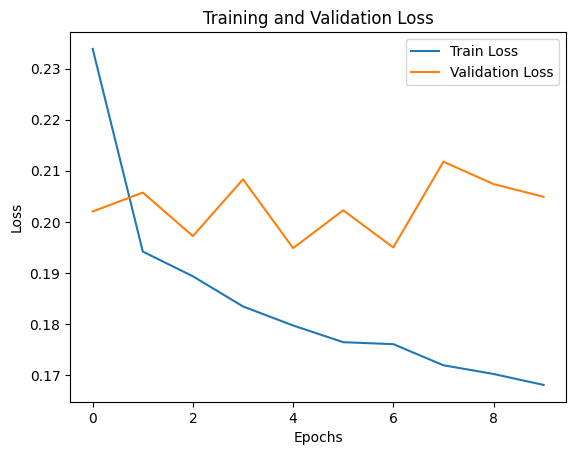

In [ ]:
def visualize_loss(train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

visualize_loss(train_loss, val_loss)

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_pos_preds = []
    all_pos_targets = []
    all_grp_preds = []
    all_grp_targets = []

    with torch.no_grad():
        for batch in loader:
            img_front = batch.input["front_images_ob"].to(device)
            img_mount = batch.input["mount_images_ob"].to(device)
            pos_obs = batch.input["pos_obs"].to(device)
            vel_obs = batch.input["vel_obs"].to(device)
            joint_obs = batch.input["joint_obs"].to(device)
            targets = {key: batch.output[key].to(device) for key in batch.output}

            predictions = model(img_front,img_mount,pos_obs, vel_obs, joint_obs)

            # Collect regression predictions and targets
            all_pos_preds.append(predictions["pos"].cpu())
            all_pos_targets.append(targets["pos"].cpu())

            # Collect classification predictions (logits -> class indices) and targets
            grp_pred_classes = predictions["grp"].argmax(dim=1)  # Convert logits to class indices
            all_grp_preds.append(grp_pred_classes.cpu())
            all_grp_targets.append(targets["grp"].argmax(dim=1).cpu())  # Convert one-hot to class indices

    all_pos_preds = torch.cat(all_pos_preds, dim=0)
    all_pos_targets = torch.cat(all_pos_targets, dim=0)
    all_grp_preds = torch.cat(all_grp_preds, dim=0)
    all_grp_targets = torch.cat(all_grp_targets, dim=0)
    return all_pos_preds, all_pos_targets, all_grp_preds, all_grp_targets
all_pos_preds, all_pos_targets, all_grp_preds, all_grp_targets = evaluate_model(model_sup, val_dataloader, device)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(all_pos_targets.numpy(), all_pos_preds.numpy())
mae = mean_absolute_error(all_pos_targets.numpy(), all_pos_preds.numpy())
r2 = r2_score(all_pos_targets.numpy(), all_pos_preds.numpy())

print(f"Regression Metrics:\nMSE: {mse}, MAE: {mae}, R²: {r2}")


Regression Metrics:
MSE: 0.004953401628881693, MAE: 0.05180678889155388, R²: 0.5613177418708801


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(all_grp_targets.numpy(), all_grp_preds.numpy())
class_report = classification_report(all_grp_targets.numpy(), all_grp_preds.numpy(), target_names=["Class 0", "Class 1", "Class 2"])
conf_matrix = confusion_matrix(all_grp_targets.numpy(), all_grp_preds.numpy())

print(f"Classification Metrics:\nAccuracy: {accuracy}")
print(class_report)
print(f"Confusion Matrix:\n{conf_matrix}")


Classification Metrics:
Accuracy: 0.8765942778352293
              precision    recall  f1-score   support

     Class 0       0.64      0.68      0.66       373
     Class 1       0.95      0.98      0.97      2161
     Class 2       0.61      0.45      0.52       367

    accuracy                           0.88      2901
   macro avg       0.74      0.70      0.72      2901
weighted avg       0.87      0.88      0.87      2901

Confusion Matrix:
[[ 254   45   74]
 [   6 2124   31]
 [ 134   68  165]]


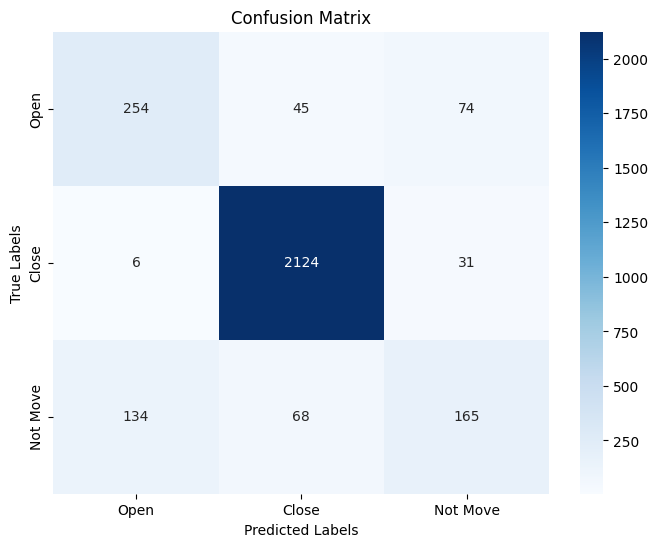

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
class_names = ["Open", "Close", "Not Move"]
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()